# On People Analytics 
## Predicting employee turnover
---

# 1.0 Understanding the context and the business

## 1.1 Motivation

In mid 2019, Gallup estimated that a trillion dollars was what U.S. businesses were losing every year due to voluntary employee turnover. In addition, in the same period, the U.S. Bureau of Labor Statistics announced that the number of American workers who quit their jobs in 2018 topped 40 million and represented 26.9% of the workforce.

For an individual organization:

- The cost of replacing an individual employee can range from one-half to two times the employee's annual salary -- and that's a conservative estimate.
- So, a 100-person organization that provides an average salary of \\$50,000 could have turnover and replacement costs of approximately \\$660,000 to \\$2.6 million per year.

With a trillion dollars on the table, businesses may also want to take other steps to curb turnover and keep their workforce happy and engaged.

When Gallup talked to exiting workers, they found two fascinating bits of information: 

- 52% of them said their manager or organization could have done something to keep them from leaving. 
- 51% said that in the three months before their departure neither their manager nor any other company leader had spoken with them about their job satisfaction or their future.

At the end of its report, Gallup suggested:

> “Train your managers to have frequent, meaningful conversations with employees about what really matters to them. What’s frustrating them? What are their dreams? Where do they want to go?”

However, for a company with many employees and bureaucratic processes, how it makes it possible to spot those employees that are most likely to leave? This is what we're going to find out in this project.

## 1.2 Defining the business metrics

Before starting to explore the data set and building a machine learning model, we need to define which business metrics we'll use to choose the right approach and select the best model that will help us solve the problem.

As mentioned early, when an employee leaves the company, the position will have to be replaced which leads to a high cost and energy consuming hiring process (head hunting, CV review, interviews, tests, onboarding, etc.)

So, when building a machine learning model we are going to focus on optimizing its performance metrics, that is, **minimizing the False Negatives while maximizing the True Positives**.

![](img/confusion-matrix.png)

In addition, we can outline a **best-worst scenario** for an employee who leaves a company.

|                                  | Best scenario | Worst scenario |
|----------------------------------|---------------|----------------|
| **Cost \($\)**                       | 4,000          | 7,645           |
| **Time to fill a position \(days\)** | 42            | 52             |

So, for example, if in our predictions from a total 100 employees who tend to leave, we correctly identify 80 (True Positives) and miss 20 (False Negatives) in the **best scenario** we would be **saving the company a total of \\$320,000 and 9 years** while in the **worst scenario, a total of \\$611,600 and 11 years** to fill all the additional 80 positions that would be open because these employees left the company.

## References

- https://business.linkedin.com/talent-solutions/blog/employee-retention/2019/gallup-suggests-employee-turnover-in-us-business-is-1-trillion-dollar-problem-with-simple-fix

- https://www.gallup.com/workplace/247391/fixable-problem-costs-businesses-trillion.aspx
 
- https://www.gallup.com/workplace/260564/heard-quit-rate-win-war-talent.aspx
 
- https://toggl.com/blog/cost-of-hiring-an-employee
 
- https://medium.com/@tatianae_79457/trabalhando-com-classes-desbalanceadas-em-problemas-machine-learning-29ee8db4a049
 
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# 2.0 Imports

These are the packages that we're using in this project. I spearated them by purpose.

In [1]:
# general utilities
import inflection
import pickle
from general_utils.GeneralUtils import GeneralUtils

# data manipulation
import pandas as pd
import numpy as np

# EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency, randint, norm

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from boruta import BorutaPy

# machine learning
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model evaluation and calibration
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold

# 3.0 Helper functions

These functions helps us have a better experience while getting our results. They make the data more readable.

In [2]:
# creates a GeneralUtils object
gu = GeneralUtils()

# sets seaborn default style
sns.set()

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = 70

# sets the global seed
SEED = 42

# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))


def get_attribute_frequency(attribute):
    
    # creates a dictionary from value counts
    count_dict_attribute = attribute.value_counts().to_dict()
    
    # stores values as DataFrame
    df_count_attribute = pd.DataFrame(count_dict_attribute.items(), columns=['Value','Count'])

    # calculates the frequency for each value
    df_count_attribute['frequency'] = df_count_attribute['Count'] / df_count_attribute['Count'].sum()
    
    # gets a dictionary for the frequency
    frequency_attribute = df_count_attribute.set_index('Value').to_dict()['frequency']
    
    return frequency_attribute


def get_encoded_frequencies(data_frame):
    
    # creates an empty DataFrame
    encoded_freq = pd.DataFrame()
    
    # creates columns for frequency
    for column in data_frame.columns:
        encoded_freq[column] = data_frame[column].map(get_attribute_frequency(data_frame[column]))
        
    return encoded_freq

# 4.0 Checking the data set

## 4.1 Data Dictionary

**IBM HR Analytics Employee Attrition & Performance**

https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

This is a fictional data set created by IBM data scientists. Since there isn't a description for all the features, I've interpreted as follows:

(Education, EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, PerformanceRating, RelationshipSatisfaction and WorkLifeBalance already had a decription from the original data set.)


| Feature name             | Data Type | Description                                                                                                                                                                                                      |
|:--------------------------|:-----------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age                      | int64     | Employee's age in years                                                                                                                                                                                          |
| Attrition                | object    | If the employee stayed of left the company \(Yes ; No\)                                                                                                                                                          |
| BusinessTravel           | object    | How often the employee has business travel \(Travel\_Rarely ; Travel\_Frequently ; Non\-Travel\)                                                                                                                 |
| DailyRate                | int64     | Employee's daily rate in USD\.                                                                                                                                                                                   |
| Department               | object    | Which department the employee belongs to \(Sales ; Research & Development ; Human Resources\)                                                                                                                    |
| DistanceFromHome         | int64     | How far the employee lives from work in kilometers\.                                                                                                                                                             |
| Education                | int64     | Employee's education level \(1 = Below College ; 2 = College ; 3 = Bachelor ; 4 = Master ; 5 = Doctor\)                                                                                                          |
| EducationField           | object    | Employee's education field \(Life Sciences ; Medical ; Marketing ; Technical Degree, Human Resources ; Other\)                                                                                                   |
| EmployeeCount            | int64     | How many employee the current record represents\.                                                                                                                                                                |
| EmployeeNumber           | int64     | Employee's unique identification number                                                                                                                                                                          |
| EnvironmentSatisfaction  | int64     | How satisfied the employee is with the company's environment \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                                 |
| Gender                   | object    | Employee's gender \(Female ; Male\)                                                                                                                                                                              |
| HourlyRate               | int64     | Employee's hourly rate in USD                                                                                                                                                                                    |
| JobInvolvement           | int64     | How involved the employee feels with his/her job \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                                             |
| JobLevel                 | int64     | Employee's job level \(1 = Junior ; 2 = Mid ; 3 = Senior ; 4 = Manager ; 5 = Director\)                                                                                                                          |
| JobRole                  | object    | Employee's job role \(Sales Executive ; Research Scientist ; Laboratory Technician ; Manufacturing Director ; Healthcare Representative ; Manager ; Sales Representative ; Research Director ; Human Resources\) |
| JobSatisfaction          | int64     | How satisfied the employee feels with his/her job \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                                            |
| MaritalStatus            | object    | Employee's marital status \(Single ; Married ; Divorced\)                                                                                                                                                        |
| MonthlyIncome            | int64     | Employee's monthly income in USD                                                                                                                                                                                 |
| MonthlyRate              | int64     | Employee's monthly rate in USD                                                                                                                                                                                   |
| NumCompaniesWorked       | int64     | Number of companies that the employee has already worked\.                                                                                                                                                       |
| Over18                   | object    | If the employee is over 18 years old \(Yes\)                                                                                                                                                                     |
| OverTime                 | object    | If the employee makes over time \(Yes ; No\)                                                                                                                                                                     |
| PercentSalaryHike        | int64     | The percentage of the amount a salary is increased                                                                                                                                                               |
| PerformanceRating        | int64     | Employee's performance rating \(1 = Low ; 2 = Good ; 3 = Excellent ;  4 = Outstanding\)                                                                                                                          |
| RelationshipSatisfaction | int64     | How satisfied the employee feels with the relationship with his/her manager \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                  |
| StandardHours            | int64     | Employee's standard hours of work per day                                                                                                                                                                        |
| StockOptionLevel         | int64     | Employee's stock option level \(refer to: [What You Should Know About Option Trading Levels](https://theoptionprophet.com/blog/what-you-should-know-about-option-trading-levels))                                                                           |
| TotalWorkingYears        | int64     | Total years that the employee has professionally worked                                                                                                                                                          |
| TrainingTimesLastYear    | int64     | Total times that the employee had a training session the last year                                                                                                                                               |
| WorkLifeBalance          | int64     | How the employee feels about his/her work life balance \(1 = Bad ; 2 = Good ; 3 = Better ; 4 = Best\)                                                                                                            |
| YearsAtCompany           | int64     | Total years that the employee has worked at the company                                                                                                                                                          |
| YearsInCurrentRole       | int64     | Total years that the employee has worked in his/her current job role                                                                                                                                             |
| YearsSinceLastPromotion  | int64     | Total years since the employee had his/her last promotion at the company                                                                                                                                         |
| YearsWithCurrManager     | int64     | Total years that the employee has worked under his/her current manager                                                                                                                                           |


## 4.2 Loading data set

In [3]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources.csv', low_memory=False)

In [4]:
df_employee

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


## 4.3 Renaming columns

In [5]:
# check the data set columns
df_employee.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [6]:
# stores the old column names
cols_old = ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

# snake case
snakecase = lambda x: inflection.underscore(x)

# creates new columns from old columns in snakecase 
cols_new = list(map(snakecase, cols_old))

# renames the old columns
df_employee.columns = cols_new

In [7]:
# check the operation
df_employee.columns

Index(['age', 'attrition', 'business_travel', 'daily_rate', 'department',
       'distance_from_home', 'education', 'education_field', 'employee_count',
       'employee_number', 'environment_satisfaction', 'gender', 'hourly_rate',
       'job_involvement', 'job_level', 'job_role', 'job_satisfaction',
       'marital_status', 'monthly_income', 'monthly_rate',
       'num_companies_worked', 'over18', 'over_time', 'percent_salary_hike',
       'performance_rating', 'relationship_satisfaction', 'standard_hours',
       'stock_option_level', 'total_working_years', 'training_times_last_year',
       'work_life_balance', 'years_at_company', 'years_in_current_role',
       'years_since_last_promotion', 'years_with_curr_manager'],
      dtype='object')

## 4.4 Checking data dimensions

In [8]:
print('Number of rows: {}'.format(df_employee.shape[0]))
print('Number of cols: {}'.format(df_employee.shape[1]))

Number of rows: 1470
Number of cols: 35


## 4.5 Checking data types

In [9]:
# check data types in data set
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         1470 non-null   int64 
 1   attrition                   1470 non-null   object
 2   business_travel             1470 non-null   object
 3   daily_rate                  1470 non-null   int64 
 4   department                  1470 non-null   object
 5   distance_from_home          1470 non-null   int64 
 6   education                   1470 non-null   int64 
 7   education_field             1470 non-null   object
 8   employee_count              1470 non-null   int64 
 9   employee_number             1470 non-null   int64 
 10  environment_satisfaction    1470 non-null   int64 
 11  gender                      1470 non-null   object
 12  hourly_rate                 1470 non-null   int64 
 13  job_involvement             1470 non-null   int6

In [10]:
# counts the number of each dtype
df_employee.dtypes.value_counts()

int64     26
object     9
dtype: int64

## 4.6 Checking missing data

In [11]:
df_employee.isna().sum()

age                           0
attrition                     0
business_travel               0
daily_rate                    0
department                    0
distance_from_home            0
education                     0
education_field               0
employee_count                0
employee_number               0
environment_satisfaction      0
gender                        0
hourly_rate                   0
job_involvement               0
job_level                     0
job_role                      0
job_satisfaction              0
marital_status                0
monthly_income                0
monthly_rate                  0
num_companies_worked          0
over18                        0
over_time                     0
percent_salary_hike           0
performance_rating            0
relationship_satisfaction     0
standard_hours                0
stock_option_level            0
total_working_years           0
training_times_last_year      0
work_life_balance             0
years_at

Since the data set is fictional, it wasn't created presenting `NaN` values.

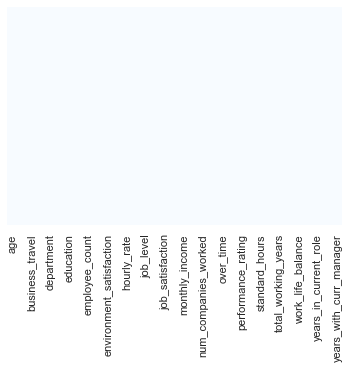

In [12]:
# Let's see if we have any missing data, luckily we don't!
_ = sns.heatmap(df_employee.isnull(), yticklabels=False, cbar=False, cmap='Blues')

## 4.7 Descriptive statistics

In [13]:
# creates a dataset for numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64'])

# creates a dataset for categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64'])

In [14]:
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [15]:
# checking the operations
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,age,18.0,60.0,42.0,36.923810,36.0,9.132266,0.413286,-0.404145
1,daily_rate,102.0,1499.0,1397.0,802.485714,802.0,403.371829,-0.003519,-1.203823
2,distance_from_home,1.0,29.0,28.0,9.192517,7.0,8.104107,0.958118,-0.224833
3,education,1.0,5.0,4.0,2.912925,3.0,1.023817,-0.289681,-0.559115
4,employee_count,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
5,employee_number,1.0,2068.0,2067.0,1024.865306,1020.5,601.819530,0.016574,-1.223179
6,environment_satisfaction,1.0,4.0,3.0,2.721769,3.0,1.092710,-0.321654,-1.202521
7,hourly_rate,30.0,100.0,70.0,65.891156,66.0,20.322512,-0.032311,-1.196398
8,job_involvement,1.0,4.0,3.0,2.729932,3.0,0.711319,-0.498419,0.270999
9,job_level,1.0,5.0,4.0,2.063946,2.0,1.106563,1.025401,0.399152


### 2.6.1 Categorical attributes

In [16]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

attrition          2
business_travel    3
department         3
education_field    6
gender             2
job_role           9
marital_status     3
over18             1
over_time          2
dtype: int64

### 2.6.2 Target var

In [17]:
# counts how many of each class we have
df_employee['attrition'].value_counts()

No     1233
Yes     237
Name: attrition, dtype: int64

As observed, we're dealing with an imbalanced data set.

## 4.8 Checkpoint

In [18]:
# saves the current data set state
df_employee.to_csv('data/Human_Resources_clean.csv', index=False)

# 5.0 Outlining the hypotheses

## 5.1 Hypothesis mindmap

![](img/mind-map.jpg)

## 5.2 Creating hypotheses

### 5.2.1 Age

1. People up to 40s tend to leave.
2. People 40+ tend not to leave.

### 5.2.2 Education

1. People that have higher degree of education tend to leave.
2. People that have lower degree of education tend not to leave.

### 5.2.3 Distance from home

1. People who live far from work tend to leave.
2. People who live near work tend not to leave.

### 5.2.4 Marital status

1. Single people tend to leave.
2. Married people tend not to leave.

### 5.2.5 Overtime

1. People who make overtime tend to leave.
2. People who don't make overtime tend to stay.

### 5.2.6 Performance rating

1. People who present higher performance ratings tend to leave.
2. People who present lower performance ratings tend to leave.
3. People who present medium performance ratings tend not to leave.

### 5.2.7 Job level and role

1. People who have lower job level tend to leave.
2. People who have medium and higher job level tend not to leave.
3. People who weren't promoted for long time tend to leave.
4. People who are in the current role for long time tend to leave.

### 5.2.8 Job involvement

1. People who feel less involved with the job tend to leave.
2. People who feel more involved with the job tend not to leave.

### 5.2.9 Job satisfaction

1. People who feel less satisfied with the job tend to leave.
2. People who feel more satisfied with the job tend not to leave.

### 5.2.10 Environment satisfaction

1. People who feel less satisfied with the environment tend to leave.
2. People who feel more satisfied with the environment tend not to leave.

### 5.2.11 Work life balance

1. People who have lower work life balance tend to leave.
2. People who have higher work life balance tend not to leave.

### 5.2.12 Working years

1. People who professionally worked for more years tend to not leave.
2. People who worked at the same company for more years tend not to leave.
3. People who are job hoppers tend to leave.

### 5.2.13 Payment

1. People who are making more money tend not to leave.
2. People who have lower salary hike tend to leave.

### 5.2.14 Training

1. People who didn't receive training for long years tend to leave.
2. People who constantly received training tend not to leave.

### 5.2.15 Current manager

1. People who have been working for the same manager for short years tend to leave.
2. People who have been working for the same manager for long years tend not to leave.
3. People who have lower quality of relationship with the manager tend to leave.
4. People who have higher quality of relationship with the manager tend not to leave.

### 5.2.16 Business travel

1. People who travel more frequently tend to leave.
2. People who don't travel tend to stay.
3. People who travel less frequently tend to stay.

### Other questions that we need to answer

1. Which departments has more turnover?
2. Which education field has more turnover?

## 5.3 Chosen hypotheses

### Age
**H1.** People up to 40s tend to leave.

### Education
**H2.** People that have higher degree of education tend to leave more.

### Distance from home
**H3.** People who live far from work tend to leave.

### Marital status
**H4.** Single people tend to leave.

### Overtime
**H5.** People who make overtime tend to leave more.

### Performance rating
**H6.**	People who present higher performance ratings tend to leave more.

**H7.**	People who present lower performance ratings tend to leave more.

### Job level and role
**H8.**	People who have lower job level tend to leave more.

**H9.**	People who weren't promoted for long time tend to leave more.

**H10.** People who are in the current role for long time tend to leave more.

### Job involvement
**H11.** People who feel less involved with the job tend to leave more.

### Job satisfaction
**H12.** People who feel less satisfied with the job tend to leave more.

### Environment satisfaction
**H13.** People who feel less satisfied with the environment tend to leave more.

### Work life balance
**H14.** People who have lower work life balance tend to leave more.

### Working years
**H15.** People who professionally worked for more years tend to not leave.

**H16.** People who worked at the same company for more years tend not to leave.

**H17.** People who are job hoppers tend to leave.

### Payment
**H18.** People who are making more money tend not to leave.

**H19.** People who have lower salary hike tend to leave.

### Training
**H20.** People who didn't receive training for long years tend to leave more.

### Current manager
**H21.** People who have been working for the same manager for short years tend to leave more.

**H22.** People who have lower quality of relationship with the manager tend to leave more.

### Business travel
**H23.** People who travel more frequently tend to leave more.

### Other questions that we need to answer
**H24.** Which departments has more turnover?

**H25.** Which education field has more turnover?

# 6.0 Feature Engineering

## 6.1 Loading data set

In [19]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources_clean.csv')

## 6.2 Column filtering

We're going to drop the columns `over18` and `standard_hours` because every employee are over 18 years and have the same standard hours.

In addition, we're dropping `employee_count` and `employee_number` because the first is the same for all employees and the second is the equivalent to employee Id which don't make sense to keep for our analysis and predictions.

In [20]:
# saves employee_number for later usage
df_emp_numb = df_employee[['employee_number']]

In [21]:
# cols to drop
cols_drop = ['over18', 'standard_hours', 'employee_count', 'employee_number']

# drops the columns
df_employee = df_employee.drop(cols_drop, axis=1)

In [22]:
# checks a single sample
df_employee.sample()

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
1425,33,No,Travel_Rarely,501,Research & Development,15,2,Medical,2,Female,95,3,2,Healthcare Representative,4,Married,4878,21653,0,Yes,13,3,1,1,10,6,3,9,7,8,1


## 6.3 Preparing data for EDA

As we have categorical data being represented by numbers, this makes our analysis a little bit more difficult, so we'll replaces thoses numbers with string categories.

In [23]:
# employee's education level
df_employee['education'] = df_employee['education'].apply(lambda x: 'Bellow College' if x == 1 
                                                          else 'College' if x == 2 
                                                          else 'Bachelor' if x == 3 
                                                          else 'Master' if x == 4 
                                                          else 'Doctor')

# how satisfied the employee is with the company's environment 
df_employee['environment_satisfaction'] = df_employee['environment_satisfaction'].apply(lambda x: 'Low' if x == 1 
                                                                                        else 'Medium' if x == 2 
                                                                                        else 'High' if x == 3 
                                                                                        else 'Very High')

# how involved the employee feels with his/her job 
df_employee['job_involvement'] = df_employee['job_involvement'].apply(lambda x: 'Low' if x == 1
                                                                      else 'Medium' if x == 2 
                                                                      else 'High' if x == 3 
                                                                      else 'Very High')

# employee's job level
df_employee['job_level'] = df_employee['job_level'].apply(lambda x: 'Junior' if x == 1
                                                                else 'Mid' if x == 2 
                                                                else 'Senior' if x == 3 
                                                                else 'Manager' if x ==4 
                                                                else 'Director')

# how satisfied the employee feels with his/her job
df_employee['job_satisfaction'] = df_employee['job_satisfaction'].apply(lambda x: 'Low' if x == 1
                                                                        else 'Medium' if x == 2
                                                                        else 'High' if x == 3 
                                                                        else 'Very High')

# employee's performance rating 
df_employee['performance_rating'] = df_employee['performance_rating'].apply(lambda x: 'Low' if x == 1
                                                                            else 'Good' if x == 2
                                                                            else 'Excellent' if x == 3 
                                                                            else 'Outstanding')

# how satisfied the employee feels with the relationship with his/her manager
df_employee['relationship_satisfaction'] = df_employee['relationship_satisfaction'].apply(lambda x: 'Low' if x == 1
                                                                                          else 'Medium' if x == 2
                                                                                          else 'High' if x == 3 
                                                                                          else 'Very High')

# how the employee feels about his/her work life balance
df_employee['work_life_balance'] = df_employee['work_life_balance'].apply(lambda x: 'Bad' if x == 1
                                                                          else 'Good' if x == 2
                                                                          else 'Better' if x == 3 
                                                                          else 'Best')

## 6.4 Checkpoint

In [24]:
# saves the current data set state
df_employee.to_csv('data/Human_Resources_fe.csv', index=False)

# 7.0 Exploratory data analysis

## 7.1 Loading data set

In [25]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources_fe.csv')

## 7.2 Separating data types

In [26]:
# gets only numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64'])

# gets only categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64'])

## 7.3 Univariate analysis

### 7.3.1 Target variable

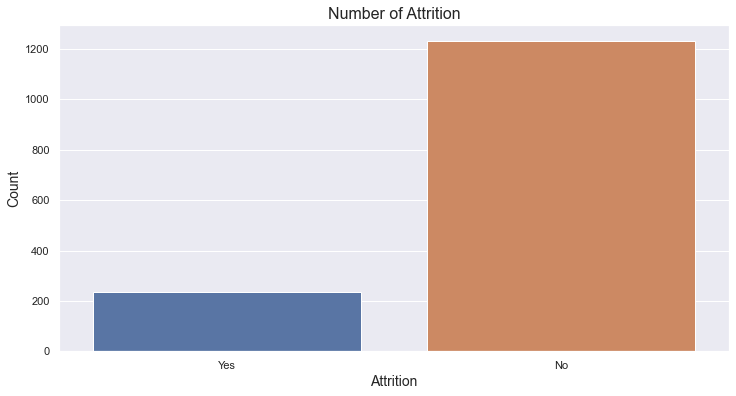

In [27]:
# plots count
ax = sns.countplot(x=df_employee['attrition'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# set plot features
ax.set_title("Number of Attrition", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Attrition", fontsize=14)

# displays plot
plt.show()

As observed, there are much more people that stayed than left the company.

In [28]:
# separating the data set for easier analysis
df_left = df_employee[df_employee['attrition'] == 'Yes']
df_stayed = df_employee[df_employee['attrition'] == 'No']

In [29]:
# Count the number of employees who stayed and left
# It seems that we are dealing with an imbalanced dataset 
total_employees_left = df_left.shape[0]
total_employees_stayed = df_stayed.shape[0]
total_employees = df_employee.shape[0]

print('Number of employees who left:', total_employees_left)
print('This is equivalent to {:.2f}% of the total employees'.format((total_employees_left/total_employees)*100))

print('\nNumber of employees who stayed:', total_employees_stayed)
print('This is equivalent to {:.2f}% of the total employees'.format((total_employees_stayed/total_employees)*100))

Number of employees who left: 237
This is equivalent to 16.12% of the total employees

Number of employees who stayed: 1233
This is equivalent to 83.88% of the total employees


### 7.3.2 Numerical variables

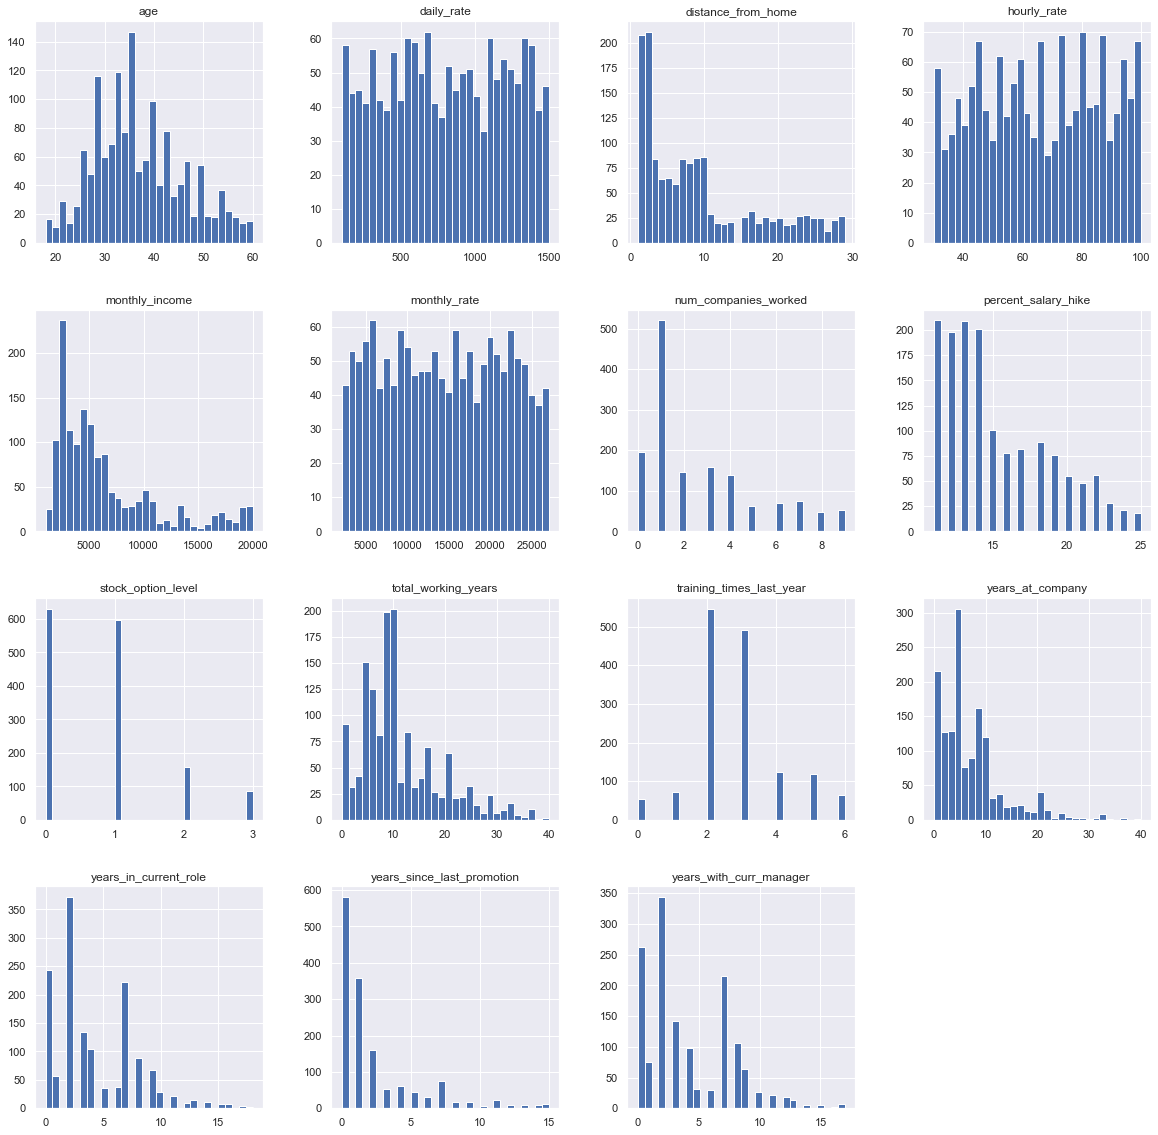

In [30]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

### 7.3.3 Categorical variables

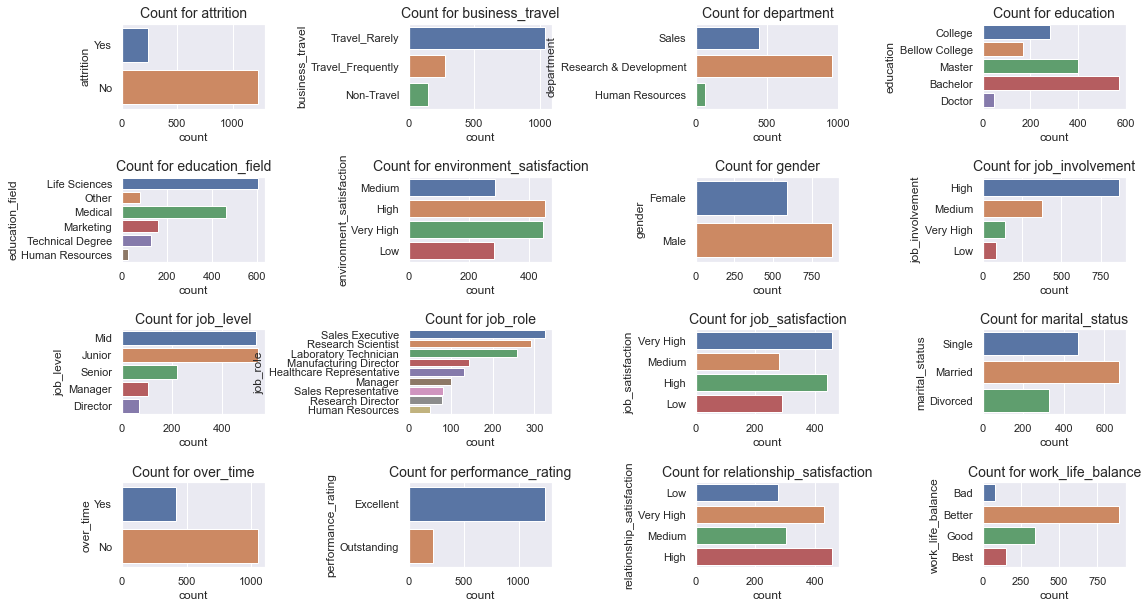

In [31]:
# sets plot size
plt.figure(figsize=(18, 10))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for column in cat_attributes.columns:
    plt.subplot(4, 4, n)
    _ = sns.countplot(y=cat_attributes[column])
    plt.title("Count for " + column, fontsize=14)
    n += 1

# adjust height and wdith reserved for space between subplots  
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=1.0)

# display the plot
plt.show()

## 7.4 Bivariate analysis - hypotheses validation

### H1. People up to 40s tend to leave. <font color="green">TRUE</font>

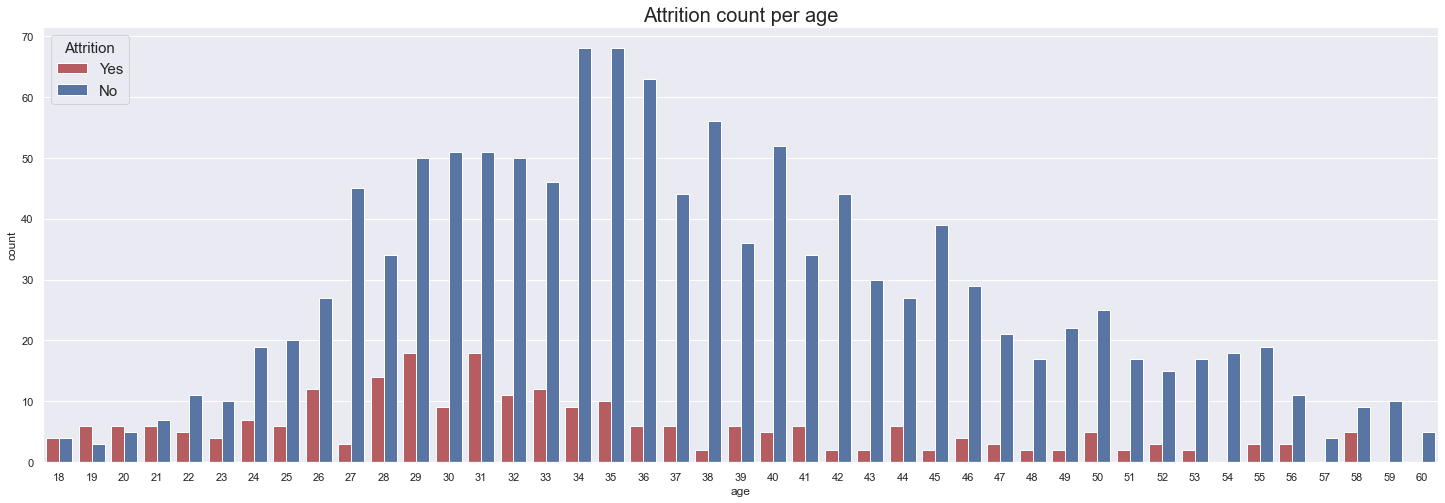

In [32]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='age', hue='attrition', data=df_employee, palette=["r", "b"])

# sets plot title
ax.set_title("Attrition count per age", fontsize=20)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

Although, up to 22 years old, comparing people who do tend to leave with who don't, the proportion of people who do tend to leave is large. In addition, it seems that people in young ages (up to 40s) tend to leave more than people in elder ages (40+). 

> Thus, the hypothesis is **TRUE**.

### H2. People that have higher degree of education tend to leave more. <font color="red">FALSE</font>

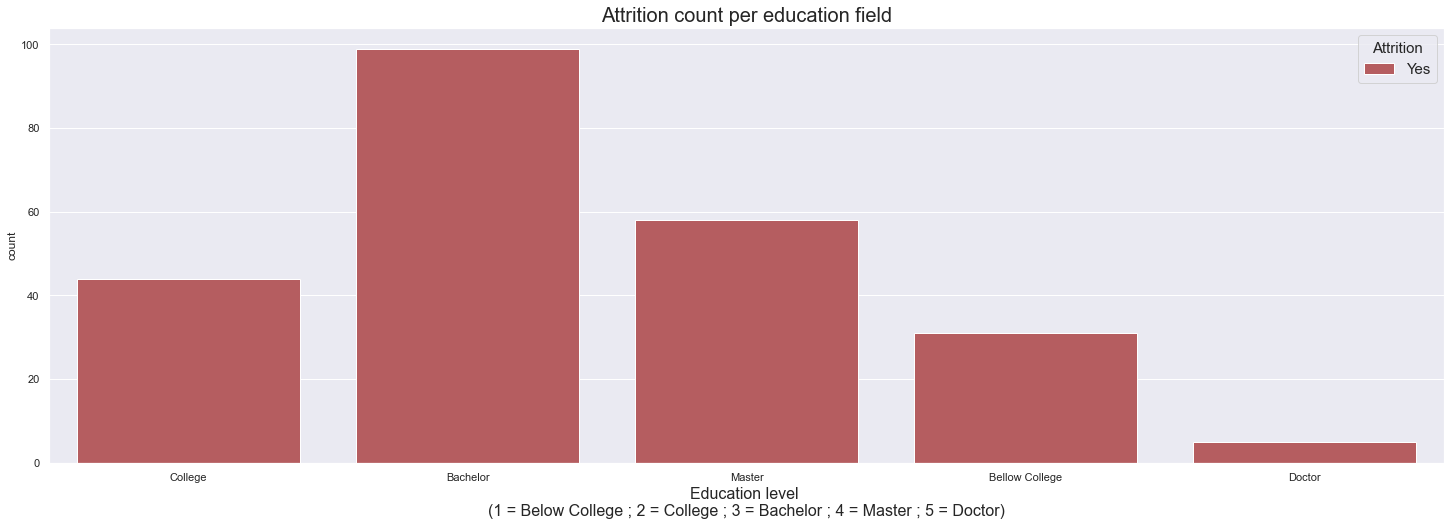

In [33]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='education', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per education field", fontsize=20)

# sets xlabel
plt.xlabel('Education level \n(1 = Below College ; 2 = College ; 3 = Bachelor ; 4 = Master ; 5 = Doctor)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people that have higher degree (**masters and doctors**) of education tend **not to leave** compared to people that have other degrees.

> Thus, the hypothesis is **FALSE**.

### H3. People who live far from work tend to leave. <font color="green">TRUE</font>

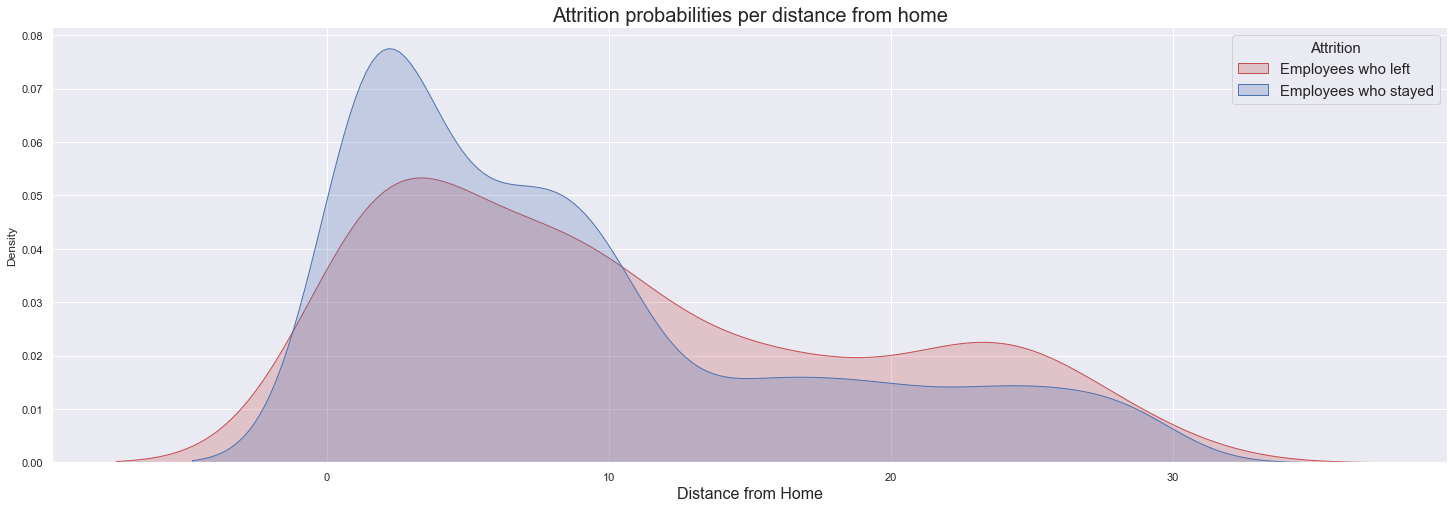

In [34]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
sns.kdeplot(df_left['distance_from_home'], label='Employees who left', shade=True, color='r')
sns.kdeplot(df_stayed['distance_from_home'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per distance from home", fontsize=20)

# sets x label
plt.xlabel('Distance from Home', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# displays the plot
plt.show()

Observing the plots, as the distance gets higher, between 12 and 28, the tendency for an employee to leave is higher.

> Thus, the hypothesis is **TRUE**.

### H4. Single people tend to leave more. <font color="green">TRUE</font>

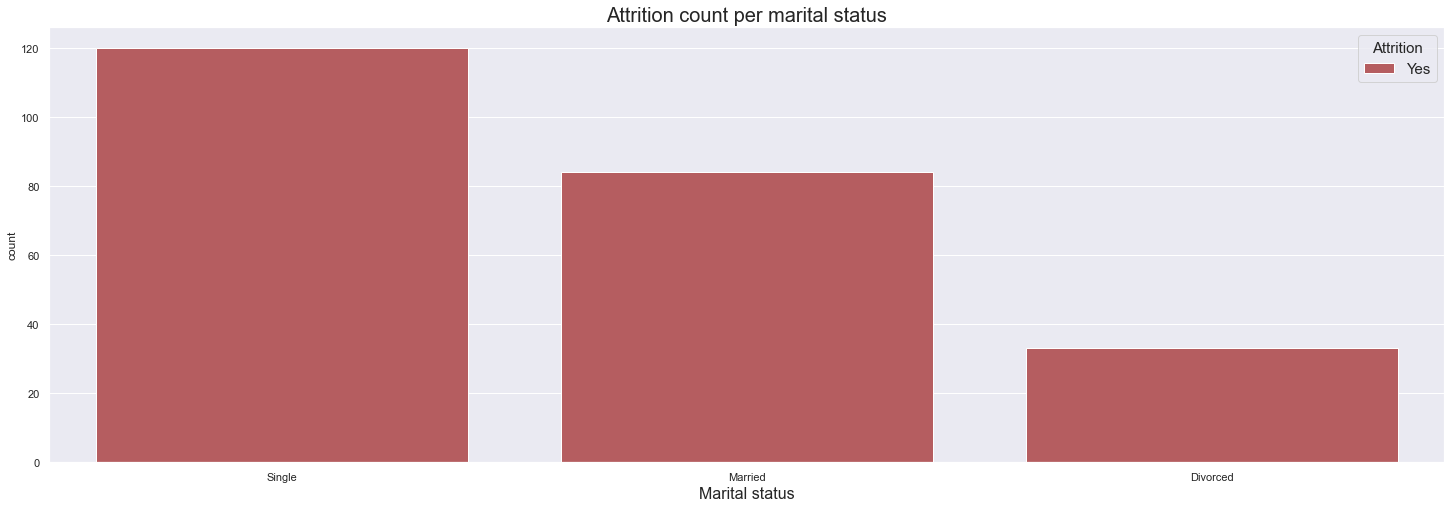

In [35]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='marital_status', hue='attrition', data=df_left, palette=['r'],
             order=df_left['marital_status'].value_counts().index)

# sets plot title
ax.set_title("Attrition count per marital status", fontsize=20)

# sets xlabel
plt.xlabel('Marital status', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, in general, people tend to stay, independently of their marital status. However, single people tend to leave more than married.

> Thus, the hypothesis is **TRUE**.

### H5. People who make overtime tend to leave more. <font color="green">TRUE</font>

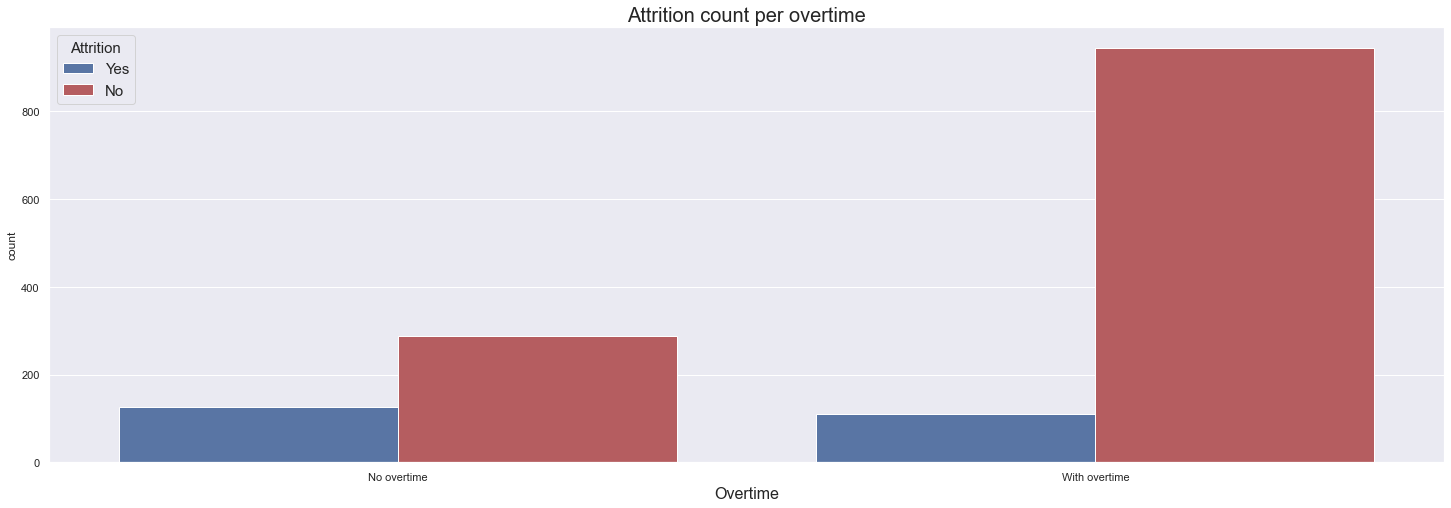

In [36]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='over_time', hue='attrition', data=df_employee, palette=["b", "r"])

# sets plot title
ax.set_title("Attrition count per overtime", fontsize=20)

# sets xlabel
plt.xlabel('Overtime', fontsize=16)

# sets xticks labels
plt.xticks([0, 1], ['No overtime','With overtime'])

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, in general, people tend to stay even when making overtime. However, they tend to stay far less when making than when not making.

> Thus, the hypothesis is **TRUE**.

### H6. People who present higher performance ratings tend to leave more. <font color="red">FALSE</font>
### H7. People who present lower performance ratings tend to leave more. <font color="red">FALSE</font>

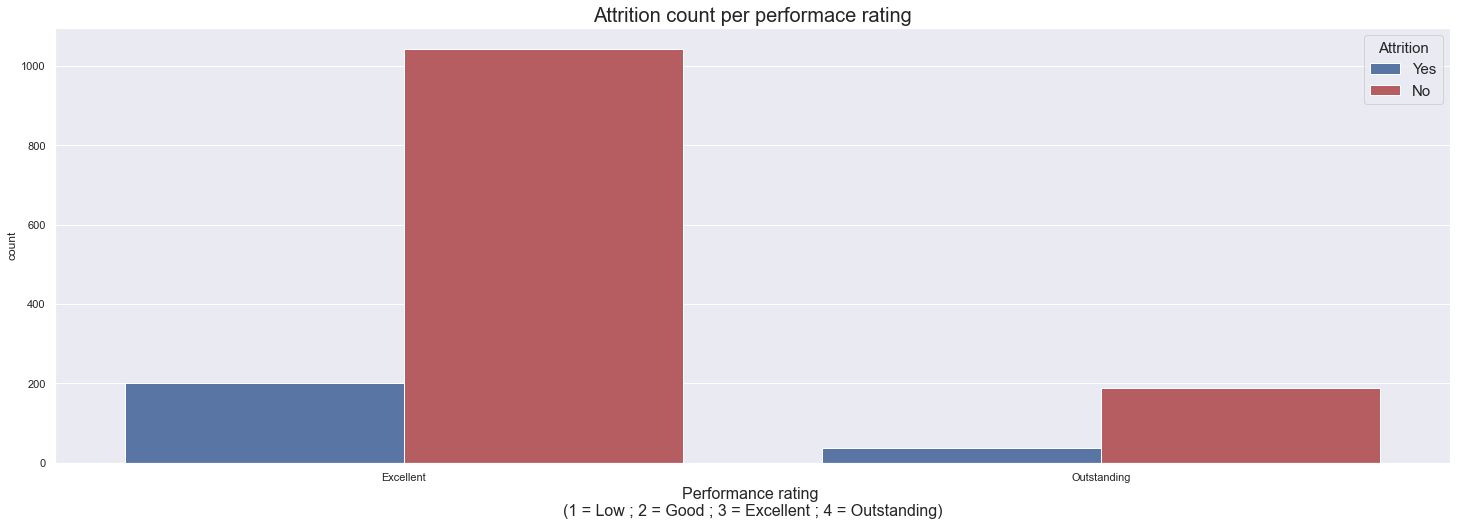

In [37]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='performance_rating', hue='attrition', data=df_employee, palette=["b", "r"])

# sets plot title
ax.set_title("Attrition count per performace rating", fontsize=20)

# sets xlabel
plt.xlabel('Performance rating \n(1 = Low ; 2 = Good ; 3 = Excellent ; 4 = Outstanding)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, in the data set there is only ratings for `Excellent` and `Outstanding`. Thus, we can only validate **H6**. So, in general, people presenting high performance ratings tend to stay. However, people who presents `Outstanding` performance ratings tend to stay far less.

> Thus, the hypothesis H7 is **TRUE** and H6 is **FALSE**.

### H8. People who have lower job level tend to leave more. <font color="green">TRUE</font>

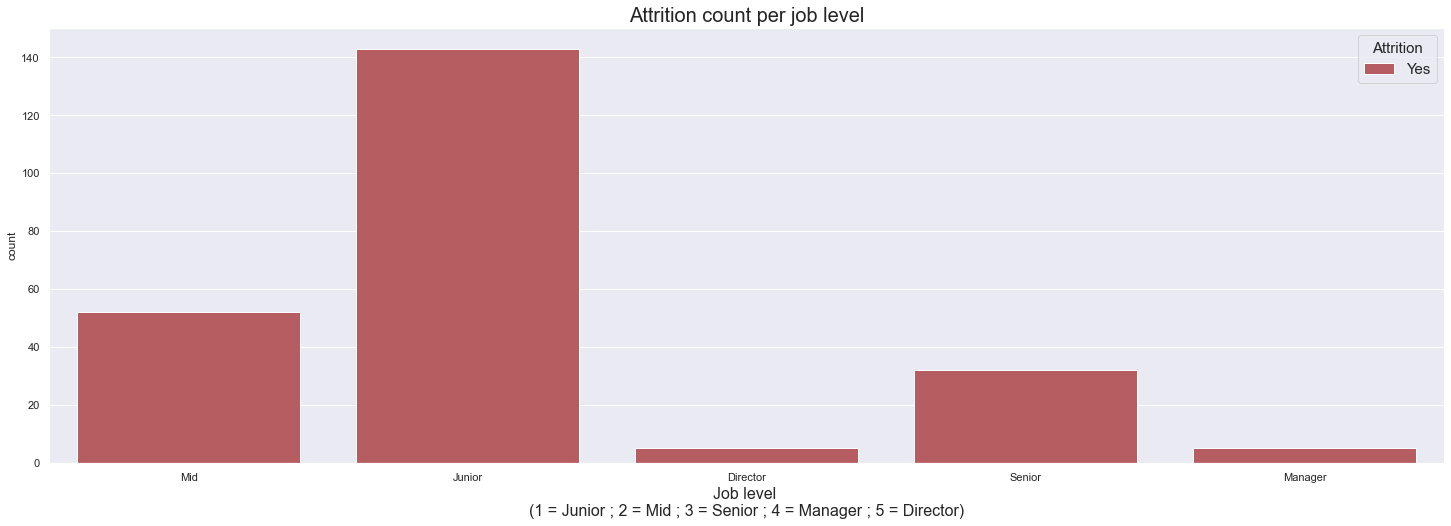

In [38]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='job_level', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per job level", fontsize=20)

# sets xlabel
plt.xlabel('Job level \n(1 = Junior ; 2 = Mid ; 3 = Senior ; 4 = Manager ; 5 = Director)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who have lower job level (`junior` and `mid`) compared to others tend to leave more.

> Thus, the hypothesis is **TRUE**.

### H9. People who weren't promoted for long time tend to leave more. <font color="red">FALSE</font>

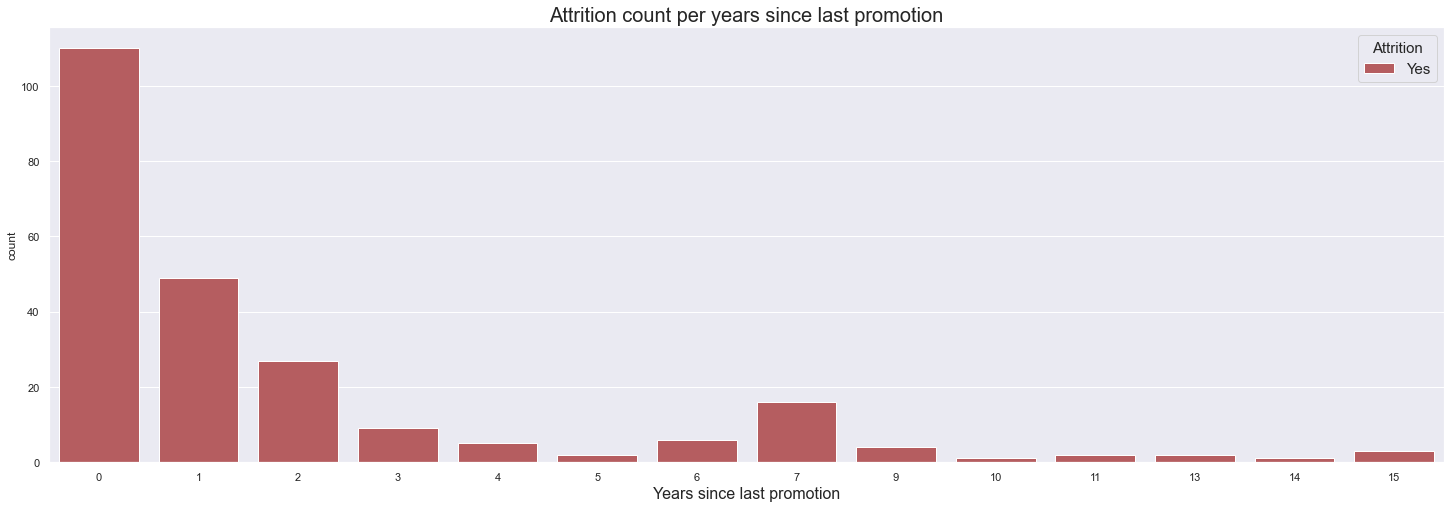

In [39]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='years_since_last_promotion', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per years since last promotion", fontsize=20)

# sets xlabel
plt.xlabel('Years since last promotion', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who weren't promoted for long time **tend to leave far less** than those who had their last promotion up to 3 years.

> Thus, the hypothesis is **FALSE**.

### H10. People who are in the current role for long time tend to leave more. <font color="red">FALSE</font>

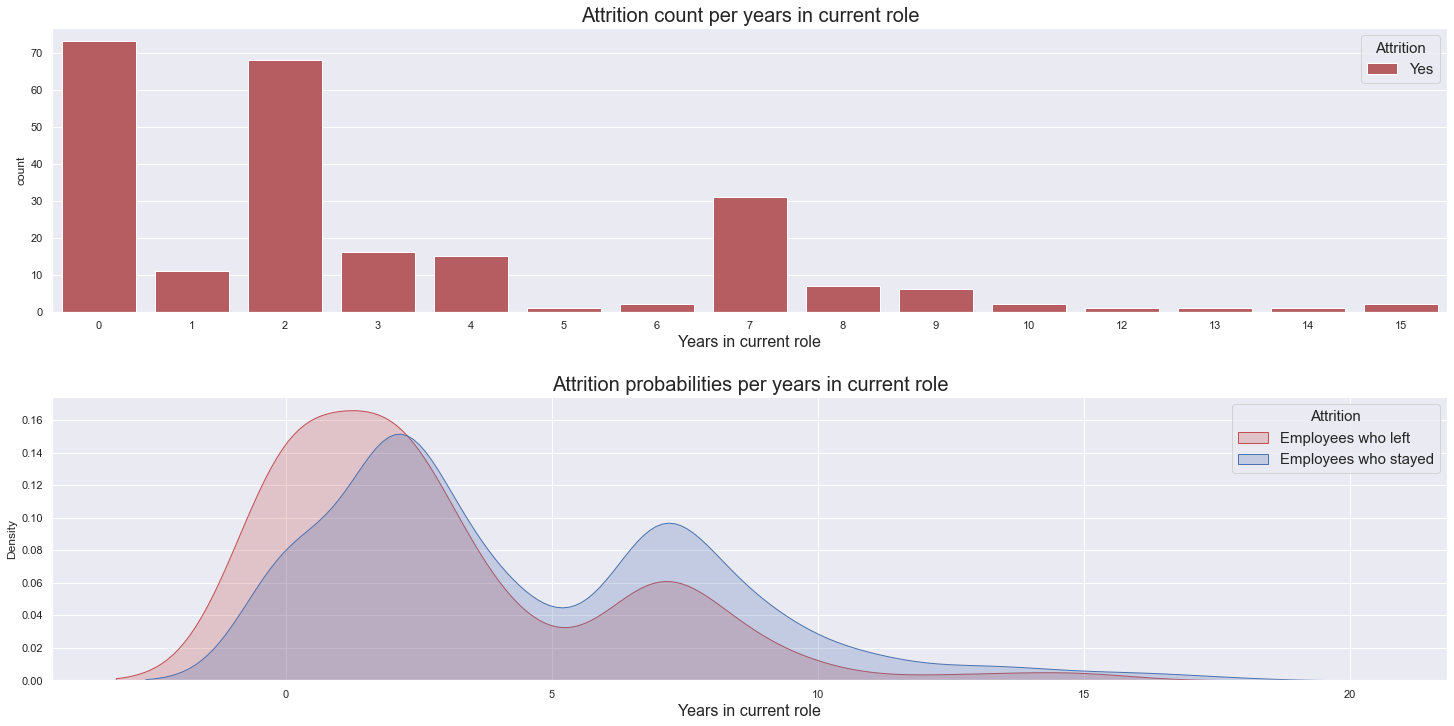

In [40]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='years_in_current_role', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per years in current role", fontsize=20)

# sets xlabel
plt.xlabel('Years in current role', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['years_in_current_role'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['years_in_current_role'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per years in current role", fontsize=20)

# sets x label
plt.xlabel('Years in current role', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who are in the current role for long time tend **not to leave**. We can ser a peak for those in the early years in current role, specifically on their first months and second year.

> Thus, the hypothesis is **FALSE**.

### H11. People who feel less involved with the job tend to leave more. <font color="red">FALSE</font>

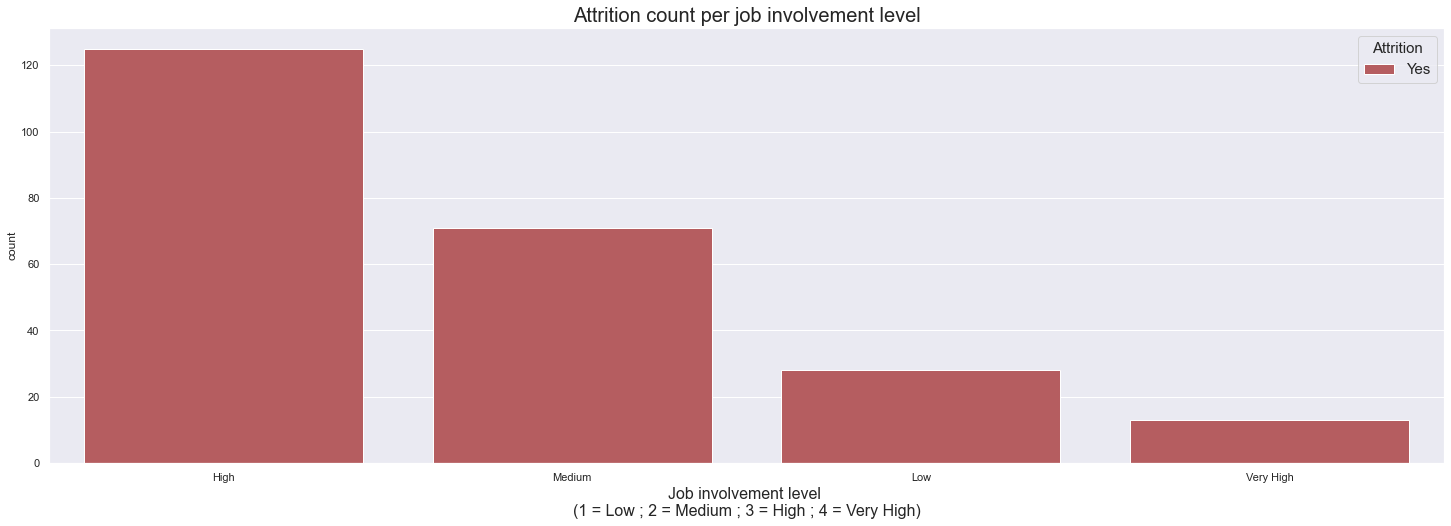

In [41]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='job_involvement', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per job involvement level", fontsize=20)

# sets xlabel
plt.xlabel('Job involvement level \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who feel less involved with the job **don't tend to leave more**.

> Thus, the hypothesis is **FALSE**.

### H12. People who feel less satisfied with the job tend to leave more. <font color="red">FALSE</font>

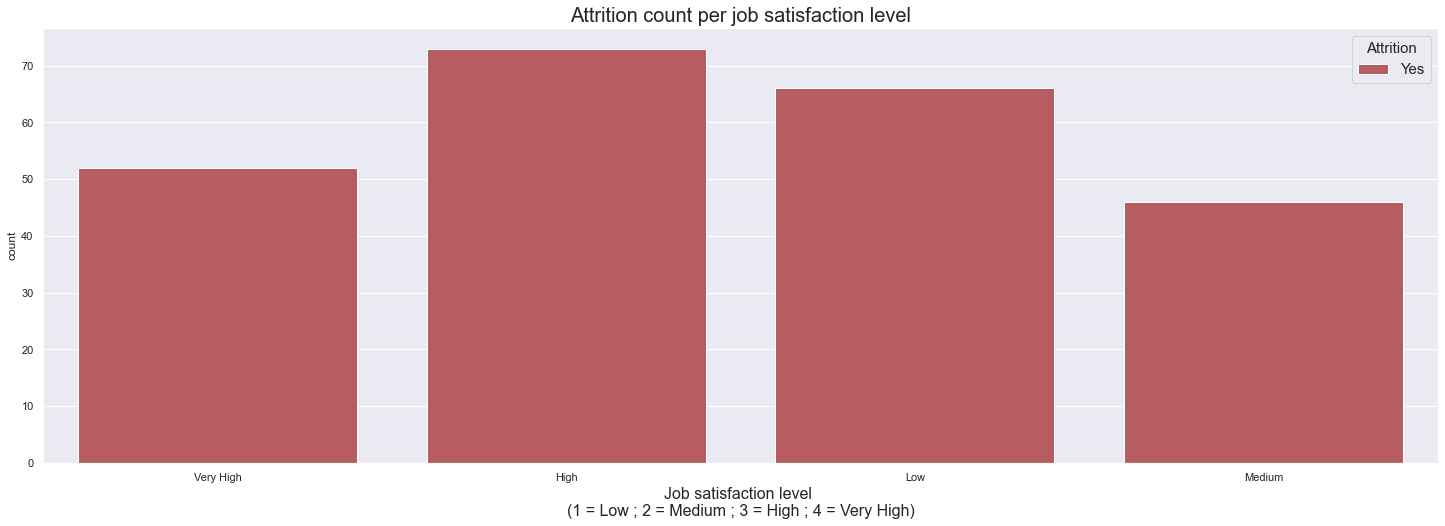

In [42]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='job_satisfaction', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per job satisfaction level", fontsize=20)

# sets xlabel
plt.xlabel('Job satisfaction level \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who feel less satisfied with the job **don't tend to leave more**.

> Thus, the hypothesis is **FALSE**.

### H13. People who feel less satisfied with the environment tend to leave more.

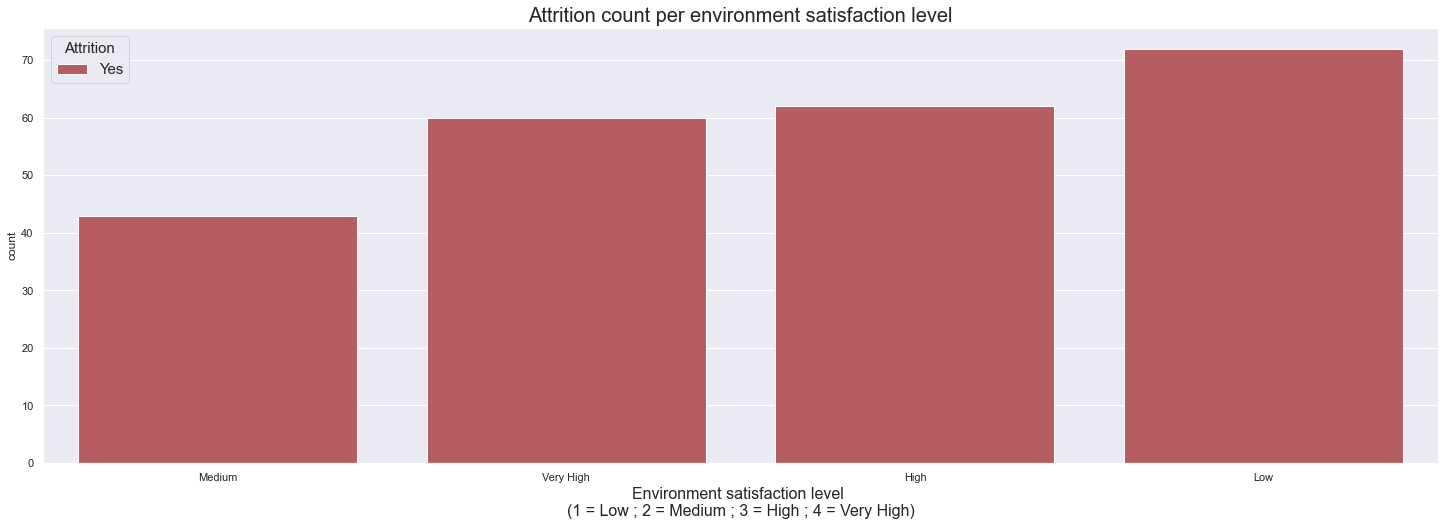

In [43]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='environment_satisfaction', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per environment satisfaction level", fontsize=20)

# sets xlabel
plt.xlabel('Environment satisfaction level \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, we can't really say if people who feel less satisfied with the environment tend to leave more, because the counts are almost equal for each level of satisfaction.

### H14. People who have lower work life balance tend to leave more. <font color="red">FALSE</font>

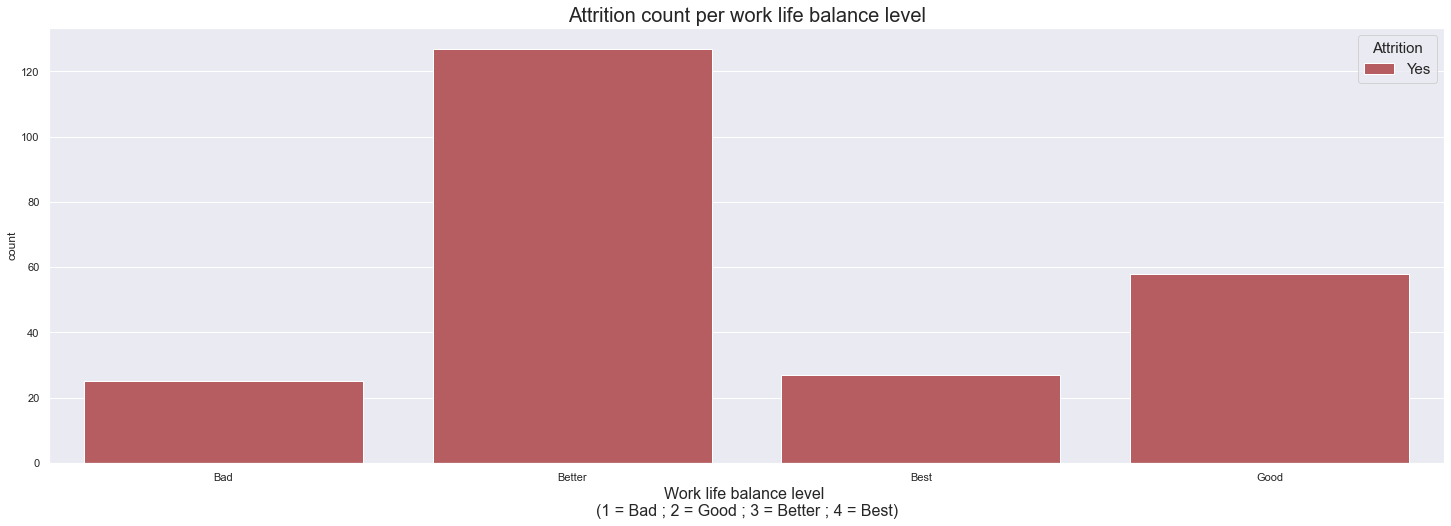

In [44]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='work_life_balance', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per work life balance level", fontsize=20)

# sets xlabel
plt.xlabel('Work life balance level \n(1 = Bad ; 2 = Good ; 3 = Better ; 4 = Best)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who have lower work life balance **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H15. People who professionally worked for more years tend to not leave. <font color="green">TRUE</font>

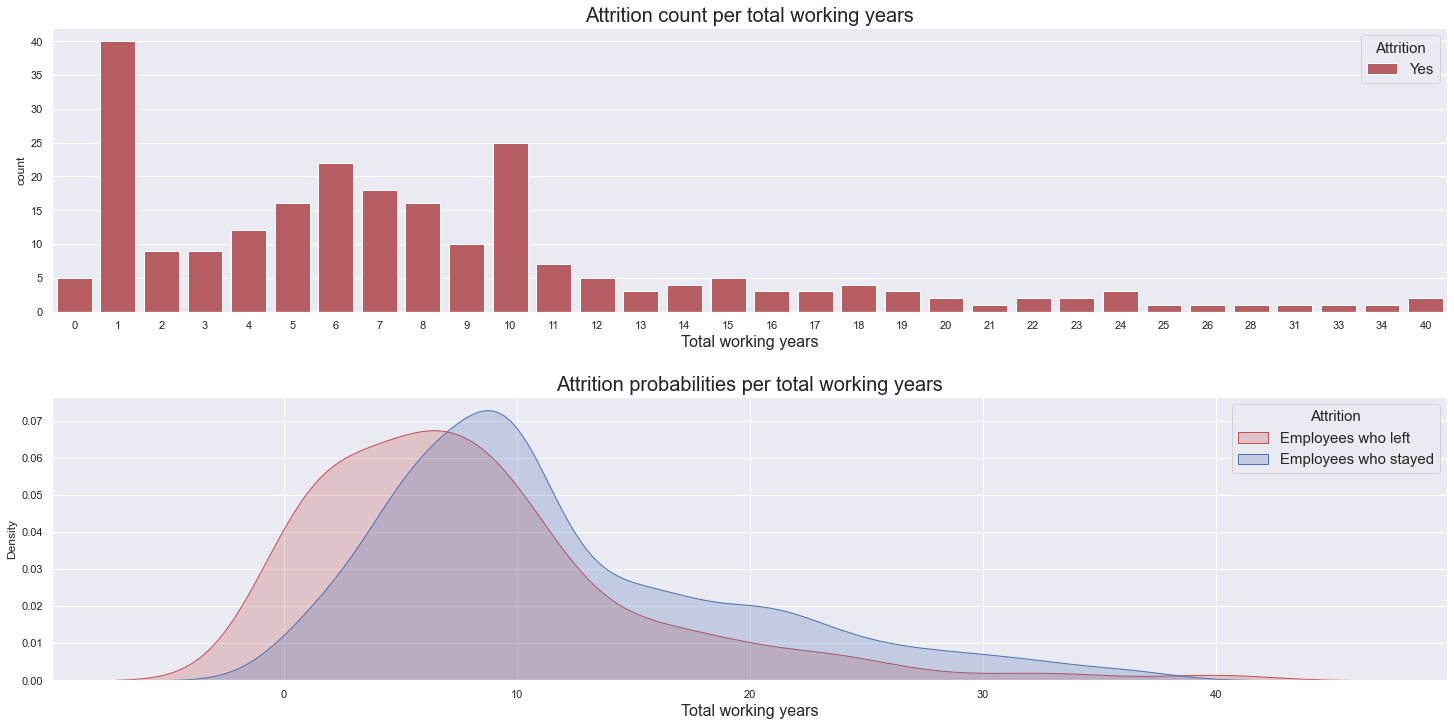

In [45]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='total_working_years', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per total working years", fontsize=20)

# sets xlabel
plt.xlabel('Total working years', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['total_working_years'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['total_working_years'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per total working years", fontsize=20)

# sets x label
plt.xlabel('Total working years', fontsize=16)

plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who professionally worked for more years **tend to not leave**. In addition, up to 10 years working professionally, people tend to leave more.

> Thus, the hypothesis is **TRUE**.

### H16. People who worked at the same company for more years tend not to leave. <font color="green">TRUE</font>

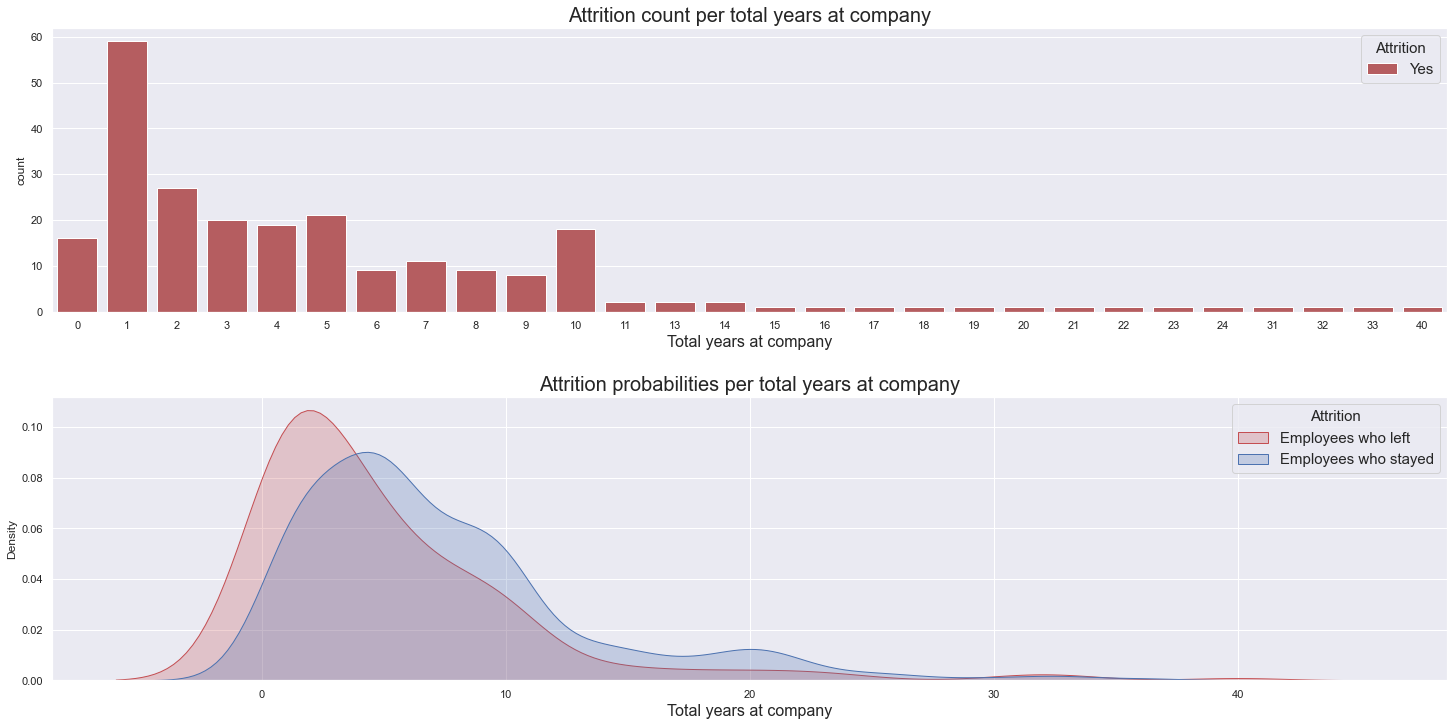

In [46]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='years_at_company', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per total years at company", fontsize=20)

# sets xlabel
plt.xlabel('Total years at company', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['years_at_company'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['years_at_company'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per total years at company", fontsize=20)

# sets x label
plt.xlabel('Total years at company', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who worked at the same company for more years **tend not to leave**.

> Thus, the hypothesis is **TRUE**.

### H17. People who are job hoppers tend to leave more. <font color="red">FALSE</font>

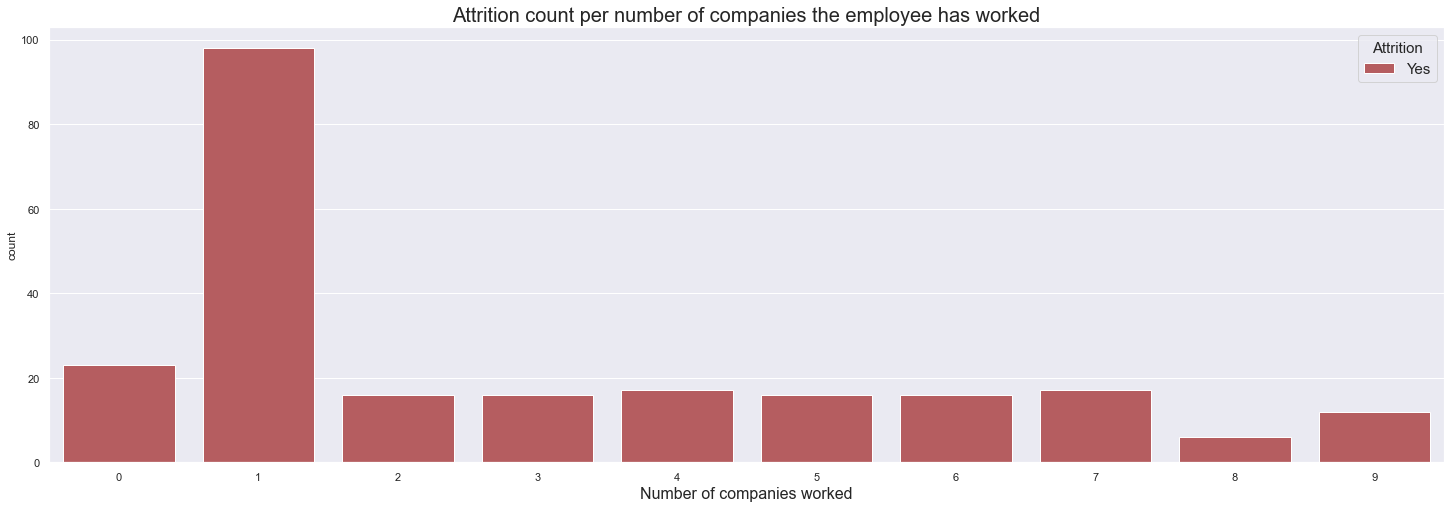

In [47]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='num_companies_worked', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per number of companies the employee has worked", fontsize=20)

# sets xlabel
plt.xlabel('Number of companies worked', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who are job hoppers **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H18. People who are making more money tend not to leave. <font color="green">TRUE</font>

In [48]:
# separates data
df_leaves_hourly_rate = df_employee[['attrition','hourly_rate']]
df_leaves_daily_rate = df_employee[['attrition','daily_rate']]
df_leaves_monthly_rate = df_employee[['attrition','monthly_rate']]

# converts to categorical
df_leaves_hourly_rate['attrition'] = df_leaves_hourly_rate['attrition'].astype('category')
df_leaves_daily_rate['attrition'] = df_leaves_daily_rate['attrition'].astype('category')
df_leaves_monthly_rate['attrition'] = df_leaves_monthly_rate['attrition'].astype('category')

<ipython-input-48-3b128911a2f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leaves_hourly_rate['attrition'] = df_leaves_hourly_rate['attrition'].astype('category')
<ipython-input-48-3b128911a2f6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leaves_daily_rate['attrition'] = df_leaves_daily_rate['attrition'].astype('category')
<ipython-input-48-3b128911a2f6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

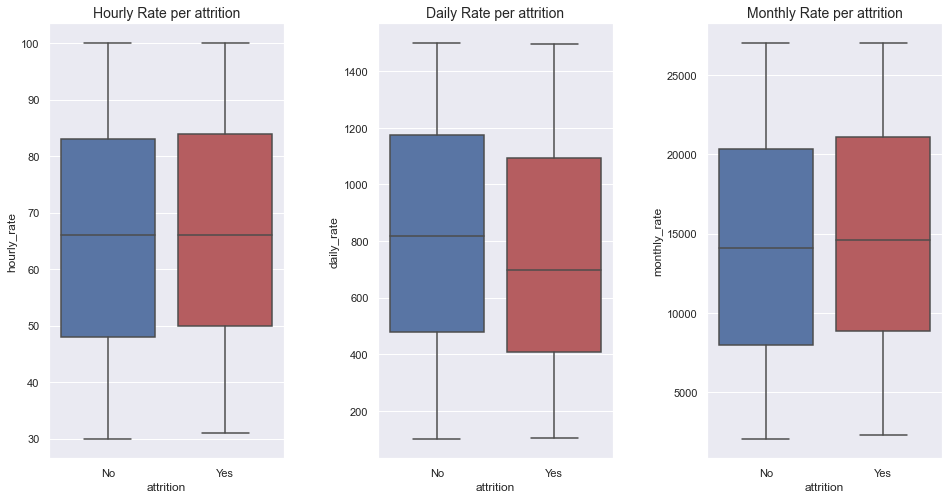

In [49]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
plt.subplot(1, 3, 1)
ax = sns.boxplot(x='attrition', y='hourly_rate',  palette=['b', 'r'], data=df_leaves_hourly_rate)
ax.set_title("Hourly Rate per attrition", fontsize=14)


# plots a scatter plot
plt.subplot(1, 3, 2)
ax = sns.boxplot(x='attrition', y='daily_rate',  palette=['b', 'r'], data=df_leaves_daily_rate)
ax.set_title("Daily Rate per attrition", fontsize=14)


# plots a scatter plot
plt.subplot(1, 3, 3)
ax = sns.boxplot(x='attrition', y='monthly_rate',  palette=['b', 'r'], data=df_leaves_monthly_rate)
ax.set_title("Monthly Rate per attrition", fontsize=14)


# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.4)

# displays the plots
plt.show()

As observed, people who are daily making more money tend to stay. As the median for hourly rate and monthly rate are quite similar.

> Thus, the hypothesis is **TRUE**.

### H19. People who have shorter salary hike range tend to leave. <font color="green">TRUE</font>

In [50]:
# separates data
df_leaves_salary_hike = df_employee[['attrition','percent_salary_hike']]

# converts to categorical
df_leaves_salary_hike['attrition'] = df_leaves_salary_hike['attrition'].astype('category')

<ipython-input-50-6410d3caf0d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leaves_salary_hike['attrition'] = df_leaves_salary_hike['attrition'].astype('category')


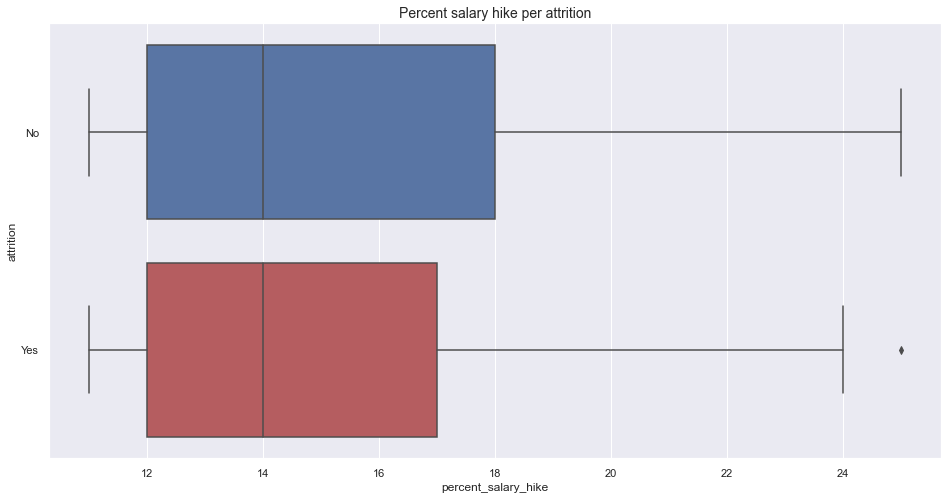

In [51]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
ax = sns.boxplot(x='percent_salary_hike', y='attrition', palette=['b', 'r'], data=df_leaves_salary_hike)
ax.set_title("Percent salary hike per attrition", fontsize=14)


# displays the plots
plt.show()

As observed, people who have shorter salary hike range **tend to leave**.

> Thus, the hypothesis is **TRUE**.

### H20. People who received less training last year tend to leave more.

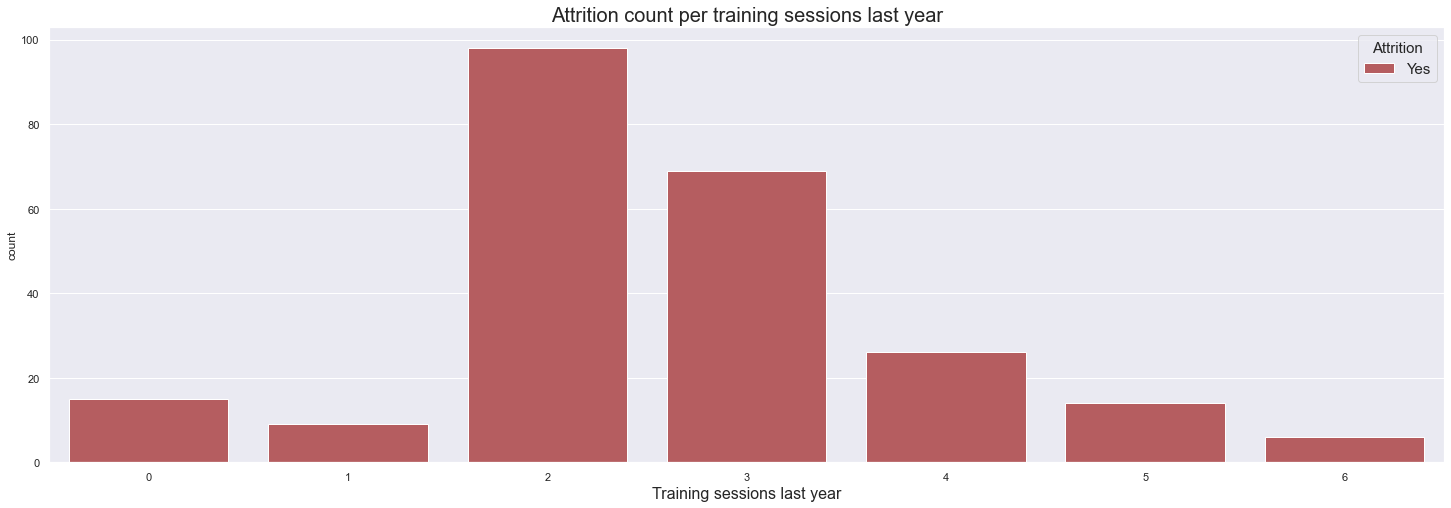

In [52]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='training_times_last_year', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per training sessions last year", fontsize=20)

# sets xlabel
plt.xlabel('Training sessions last year', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

People who received few and many training sessions last year **tend to stay**. However, people who are in the middle tend to leave.

### H21. People who have been working for the same manager for short years tend to leave more. <font color="green">TRUE</font>

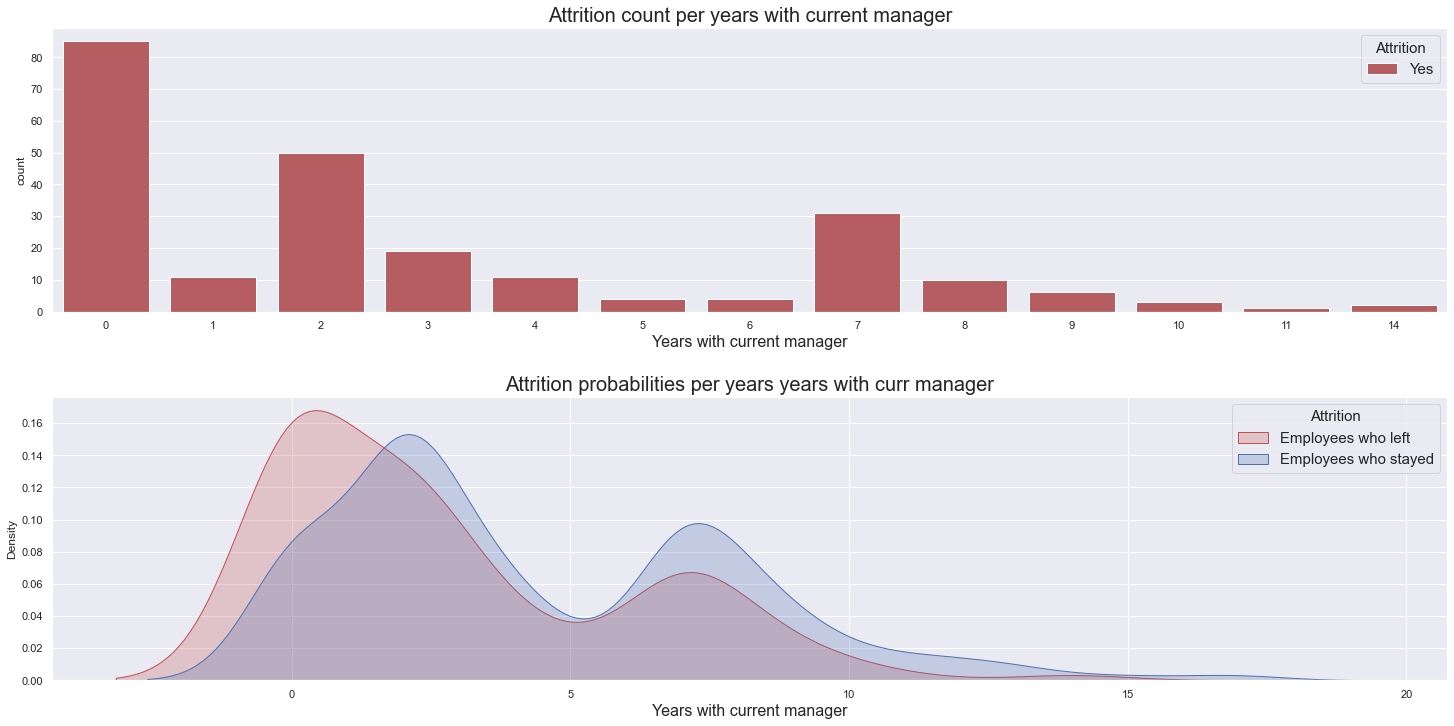

In [53]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='years_with_curr_manager', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per years with current manager", fontsize=20)

# sets xlabel
plt.xlabel('Years with current manager', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['years_with_curr_manager'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['years_with_curr_manager'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per years years with curr manager", fontsize=20)

# sets x label
plt.xlabel('Years with current manager', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who have been working for the same manager for short years **tend to leave more**.

> Thus, the hypothesis is **TRUE**.

### H22. People who have lower quality of relationship with the manager tend to leave more. <font color="red">FALSE</font>

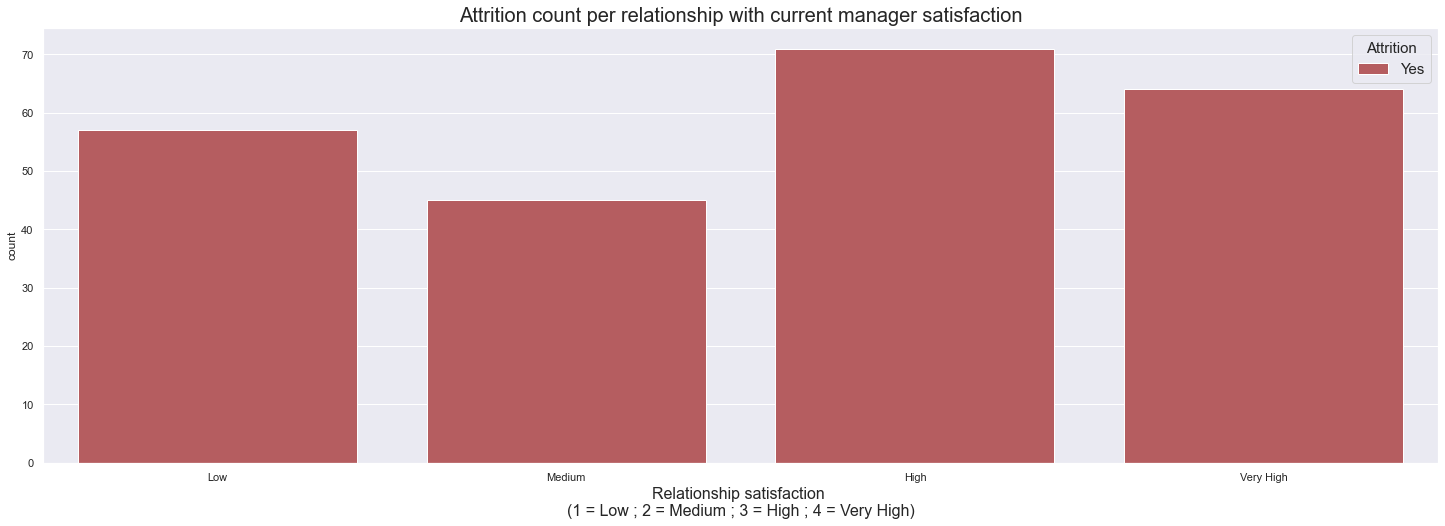

In [54]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='relationship_satisfaction', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per relationship with current manager satisfaction", fontsize=20)

# sets xlabel
plt.xlabel('Relationship satisfaction \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who have lower quality of relationship with the manager **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H23. People who travel more frequently tend to leave more. <font color="red">FALSE</font>

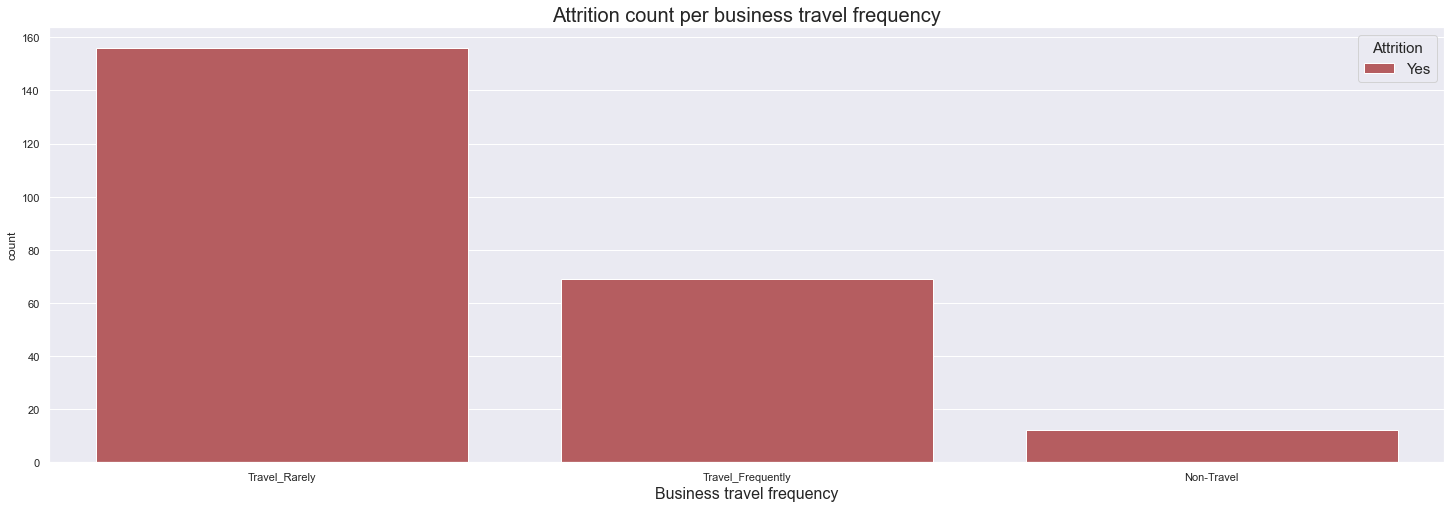

In [55]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='business_travel', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per business travel frequency", fontsize=20)

# sets xlabel
plt.xlabel('Business travel frequency', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who travel more frequently **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H24. Which departments has more turnover?

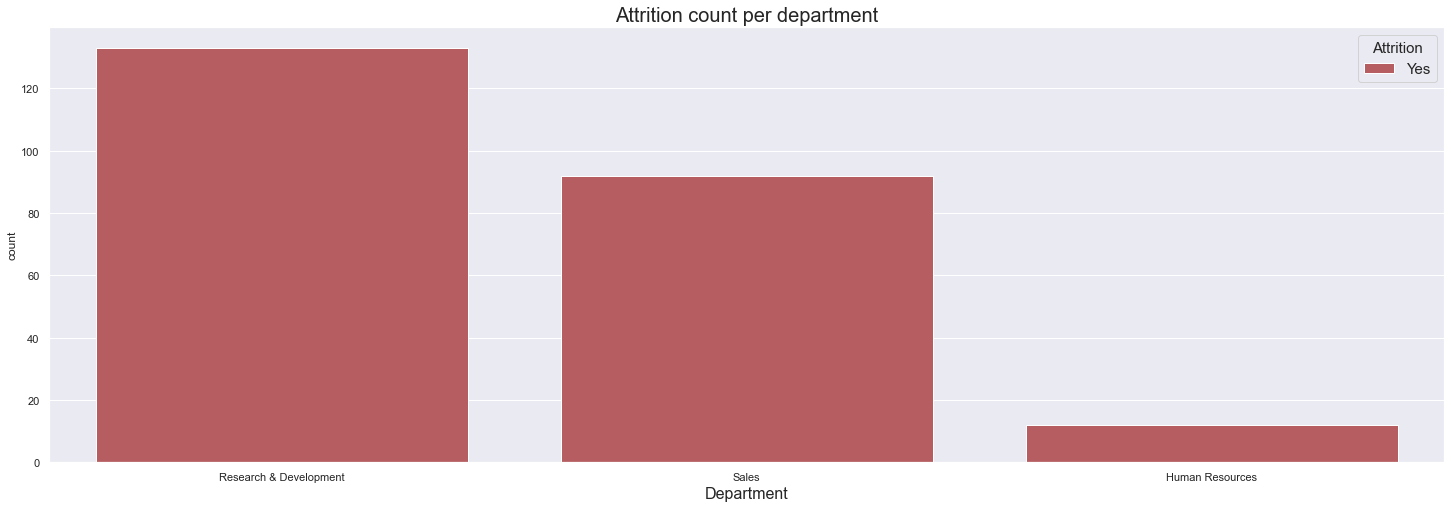

In [56]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='department', hue='attrition', data=df_left, palette=['r'],
             order=df_left['department'].value_counts().index)

# sets plot title
ax.set_title("Attrition count per department", fontsize=20)

# sets xlabel
plt.xlabel('Department', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, **Research & Development has more turnovers** than other departments.

### H25. Which education field has more turnover?

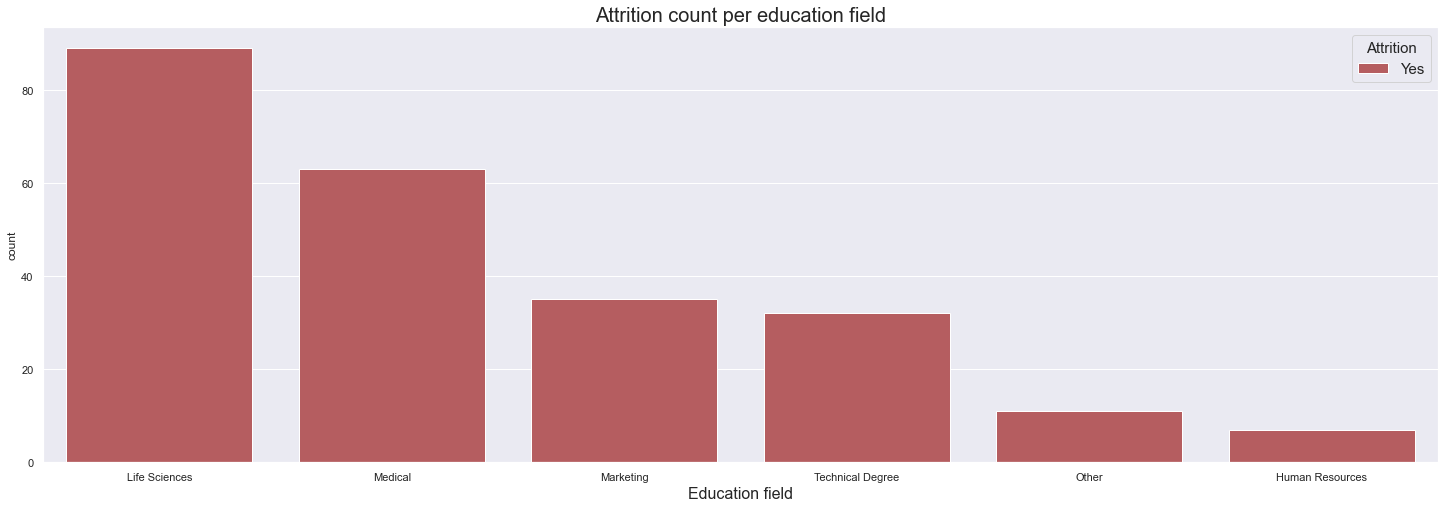

In [57]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='education_field', hue='attrition', data=df_left, palette=['r'],
             order=df_left['education_field'].value_counts().index)

# sets plot title
ax.set_title("Attrition count per education field", fontsize=20)

# sets xlabel
plt.xlabel('Education field', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, **Life Sciences** is the education field which has more turnover, followed by Medical and Marketing.

### 7.4.1 Hypotheses Summary

| ID  | Hypothesis                                                                           | Conclusion                                                                                                                                                                     |
|-----|--------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| H1  | People up to 40s tend to leave                                                       | TRUE                                                                                                                                                                           |
| H2  | People that have higher degree of education tend to leave more                       | FALSE                                                                                                                                                                          |
| H3  | People who live far from work tend to leave                                          | TRUE                                                                                                                                                                           |
| H4  | Single people tend to leave more                                                     | TRUE                                                                                                                                                                           |
| H5  | People who make overtime tend to leave more                                          | TRUE                                                                                                                                                                           |
| H6  | People who present higher performance ratings tend to leave more                     | FALSE                                                                                                                                                                          |
| H7  | People who present lower performance ratings tend to leave more                      | FALSE                                                                                                                                                                          |
| H8  | People who have lower job level tend to leave more                                   | TRUE                                                                                                                                                                           |
| H9  | People who weren't promoted for long time tend to leave more                         | FALSE                                                                                                                                                                          |
| H10 | People who are in the current role for long time tend to leave more                  | FALSE                                                                                                                                                                          |
| H11 | People who feel less involved with the job tend to leave more                        | FALSE                                                                                                                                                                          |
| H12 | People who feel less satisfied with the job tend to leave more                       | FALSE                                                                                                                                                                          |
| H13 | People who feel less satisfied with the environment tend to leave more               | As observed, we can't really say if people who feel less satisfied with the environment tend to leave more, because the counts are almost equal for each level of satisfaction |
| H14 | People who have lower work life balance tend to leave more                           | FALSE                                                                                                                                                                          |
| H15 | People who professionally worked for more years tend to not leave                    | TRUE                                                                                                                                                                           |
| H16 | People who worked at the same company for more years tend not to leave               | TRUE                                                                                                                                                                           |
| H17 | People who are job hoppers tend to leave more                                        | FALSE                                                                                                                                                                          |
| H18 | People who are making more money tend not to leave                                   | TRUE                                                                                                                                                                           |
| H19 | People who have shorter salary hike range tend to leave                              | TRUE                                                                                                                                                                           |
| H20 | People who received less training last year tend to leave more                       | People who received few and many training sessions last year tend to stay\. However, people who are in the middle tend to leave                                                |
| H21 | People who have been working for the same manager for short years tend to leave more | TRUE                                                                                                                                                                           |
| H22 | People who have lower quality of relationship with the manager tend to leave more    | FALSE                                                                                                                                                                          |
| H23 | People who travel more frequently tend to leave more                                 | FALSE                                                                                                                                                                          |
| H24 | Which departments has more turnover?                                                 | As observed, Research & Development has more turnovers than other departments                                                                                                  |
| H25 | Which education field has more turnover?                                             | As observed, Life Sciences is the education field which has more turnover, followed by Medical and Marketing                                                                   |


## 7.5 Multivariate analysis - correlations

### 7.5.1 Correlation between numerical attributes (explanatory vars)

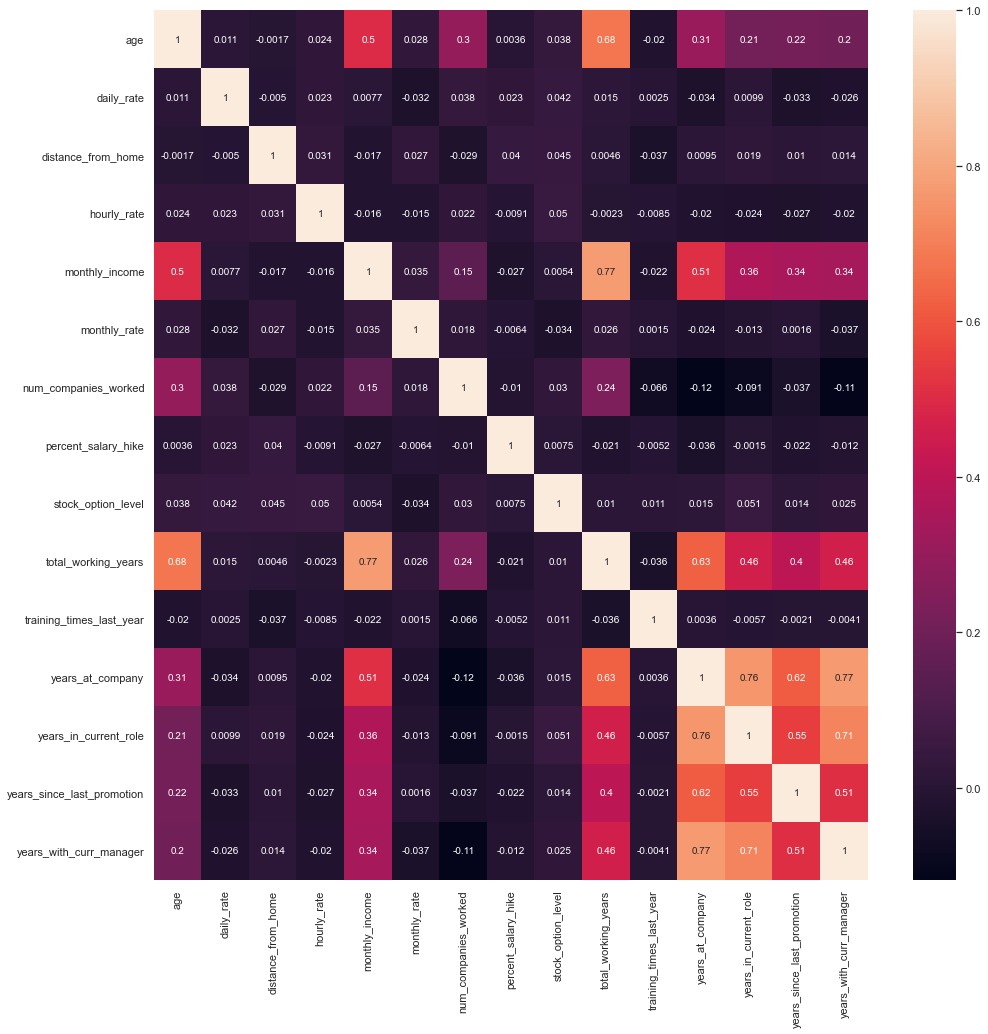

In [58]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()

### 7.5.2 Correlations between categorical attributes (explanatory vars)

In [59]:
cat_attributes.head()

,attrition,business_travel,department,education,education_field,environment_satisfaction,gender,job_involvement,job_level,job_role,job_satisfaction,marital_status,over_time,performance_rating,relationship_satisfaction,work_life_balance
0,Yes,Travel_Rarely,Sales,College,Life Sciences,Medium,Female,High,Mid,Sales Executive,Very High,Single,Yes,Excellent,Low,Bad
1,No,Travel_Frequently,Research & Development,Bellow College,Life Sciences,High,Male,Medium,Mid,Research Scientist,Medium,Married,No,Outstanding,Very High,Better
2,Yes,Travel_Rarely,Research & Development,College,Other,Very High,Male,Medium,Junior,Laboratory Technician,High,Single,Yes,Excellent,Medium,Better
3,No,Travel_Frequently,Research & Development,Master,Life Sciences,Very High,Female,High,Junior,Research Scientist,High,Married,Yes,Excellent,High,Better
4,No,Travel_Rarely,Research & Development,Bellow College,Medical,Low,Male,High,Junior,Laboratory Technician,Medium,Married,No,Excellent,Very High,Better


In [60]:
# builds contingency matrix
contigency_matrix = pd.crosstab(cat_attributes['job_role'], cat_attributes['department']).values

# getting the chi-squared
chi2 = chi2_contingency(contigency_matrix)[0]

# getting the sum of all values in the matrix
n = contigency_matrix.sum()

# getting the rows, cols
r, k = contigency_matrix.shape

# calculates Cramér V
cramer_v_val = np.sqrt((chi2/n) / min(k-1, r-1))

# makes all the possible combinations between categorical variables
a1 = cramer_v(cat_attributes['job_role'], cat_attributes['job_role'])
a2 = cramer_v(cat_attributes['job_role'], cat_attributes['department'])
a3 = cramer_v(cat_attributes['job_role'], cat_attributes['business_travel'])

a4 = cramer_v(cat_attributes['department'], cat_attributes['job_role'])
a5 = cramer_v(cat_attributes['department'], cat_attributes['department'])
a6 = cramer_v(cat_attributes['department'], cat_attributes['business_travel'])

a7 = cramer_v(cat_attributes['over_time'], cat_attributes['job_role'])
a8 = cramer_v(cat_attributes['over_time'], cat_attributes['department'])
a9 = cramer_v(cat_attributes['over_time'], cat_attributes['business_travel'])

# builds the dataset to make the correlations
d = pd.DataFrame({'job_role': [a1, a2, a3],
                  'department': [a4, a5, a6],
                  'business_travel': [a7, a8, a9]
                 })

# sets index equal to columns
d = d.set_index(d.columns)
d

,job_role,department,business_travel
job_role,1.002732,0.940031,0.066840
department,0.940031,1.000681,0.007924
business_travel,0.063869,0.008236,0.044065


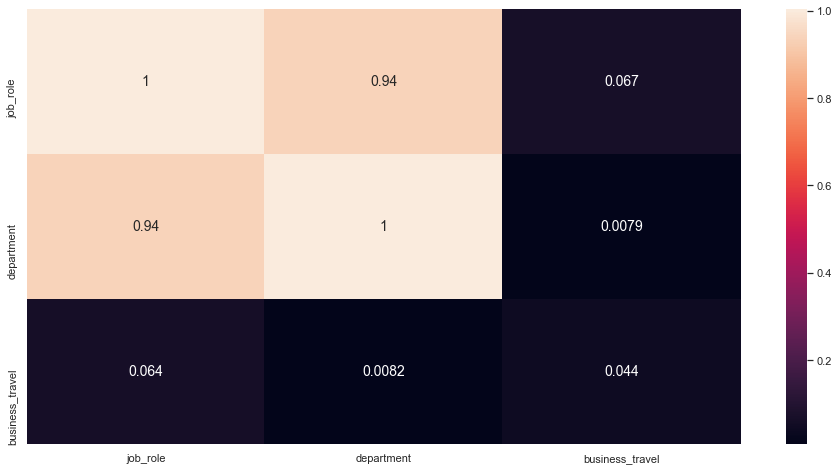

In [61]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(d, annot=True, annot_kws={"fontsize":14})

# displays plot
plt.show()

As observed, there is a strong positive correlation between `department` and `job_role`.

# 8.0 Data preprocessing

## 8.1 Loading data set

In [62]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources_fe.csv')

In [63]:
df_employee.sample()

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
153,45,No,Travel_Rarely,194,Research & Development,9,Bachelor,Life Sciences,Medium,Male,60,High,Mid,Laboratory Technician,Medium,Divorced,2348,10901,8,No,18,Excellent,High,1,20,2,Bad,17,9,0,15


## 8.2 Separating data types

In [64]:
# gets the target var
target_var = df_employee[['attrition']]

# gets only numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64'])

# gets only binary attributes
binary_attributes = df_employee[['over_time', 'gender']]

# gets only categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64'])

# drops the target var and binary attribute
cat_attributes.drop(['attrition','over_time', 'gender'], axis=1, inplace=True)

/Users/brunokatekawa/.pyenv/versions/3.8.5/envs/study_env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 8.3 Normalization

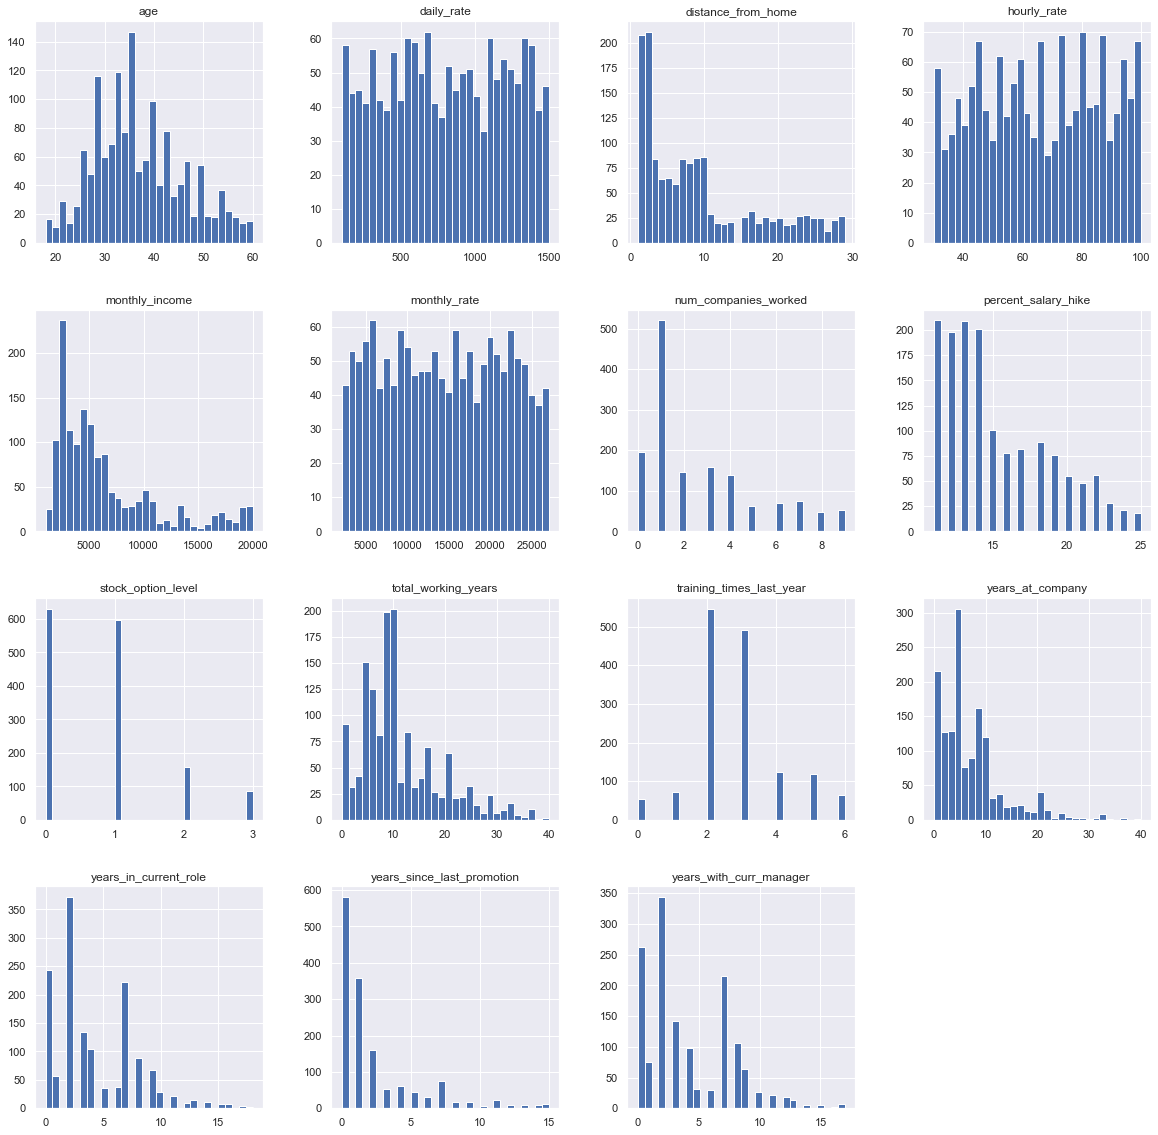

In [65]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

As we can observe, despite the `age` variable, there is no other variable presenting a normal distribution, not even nearly normal. Even though, `age` doesn't present a completely normal distribution. So, it is preferred to leave as it is than to risk a erroneous normalization.

## 8.4 Scaling numerical var

In [66]:
# instantiates the classes
mms = MinMaxScaler()

In [67]:
# we need to scale the data because the range of variables vary a lot within them
# treat the features equally
scaled_numerical = mms.fit_transform(num_attributes)

# saves the rescaling
pickle.dump(mms, open('parameter/numerical_vars_scaler.pkl', 'wb'))

In [68]:
# gets the Data Frame version of numerical scaled for later manipulation
df_scaled_numerical = pd.DataFrame(scaled_numerical)

# renaming the columns of result Data Frame
df_scaled_numerical.columns = num_attributes.columns

## 8.5 Transformation

### 8.5.1 Encoding binary attributes and target

In [69]:
# creates an empty DataFrame
df_binary_att_encoded = pd.DataFrame()

# encondes over_time
df_binary_att_encoded['over_time'] = binary_attributes['over_time'].apply(lambda x: 1 if x == 'Yes' 
                                                                          else 0)

# encondes gender
df_binary_att_encoded['gender'] = binary_attributes['gender'].apply(lambda x: 1 if x == 'Male'
                                                                    else 0)

# encondes target_var attrition
target_var['attrition'] = target_var['attrition'].apply(lambda x: 1 if x == 'Yes' else 0)


<ipython-input-69-a313545583ab>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_var['attrition'] = target_var['attrition'].apply(lambda x: 1 if x == 'Yes' else 0)


### 8.5.2 Frequency encoding categorical atrributes

As the categorical attributes have many unique values, it's not recommended to one-hot encode them as our data set dimension would increase too much. Thus, we can avoid it by making frequency encoding.

In [70]:
# resets the index
cat_attributes.reset_index(drop=True, inplace=True)

In [71]:
# frequency encodes categorical vars
cat_attr_freq_encoded = get_encoded_frequencies(cat_attributes)

## 8.6 Joining everything

In [72]:
# joins scaled with encoded attributes
df_employee_prep = pd.concat([target_var, df_scaled_numerical, df_binary_att_encoded, cat_attr_freq_encoded], axis=1)

## 8.7 Checkpoint

In [73]:
# saves data set current state
df_employee_prep.to_csv('data/Human_Resources_prep.csv', index=False)

# 9.0 Feature selection

## 9.1 Loading data set

In [74]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources_prep.csv')

## 9.2 Boruta as feature selector

In [75]:
# define training test data for Boruta
X = df_employee.drop('attrition', axis=1).values
y = df_employee['attrition'].values.ravel()

In [76]:
# define RandomForestClassifier
# uses all cores from CPU
rf_clf = RandomForestClassifier(n_jobs=-1)

In [77]:
# define Boruta
boruta = BorutaPy(rf_clf, n_estimators='auto', verbose=2, random_state=42).fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	24
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	5
Rejected: 	24
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	5
Rejected: 	24
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	5
Rejected: 	24
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	25
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	25
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	25
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	25
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	4
Rejected: 	25
I

## 9.3 Best features from Boruta

In [78]:
# gets the ranked list of features
cols_selected = boruta.support_.tolist()
df_employee.drop('attrition', axis=1).iloc[:, cols_selected].columns.to_list()

['monthly_income']

# 10.0 Machine Learning modeling

### **Tagert variable:** `attrition` (`0` = No. Employee may not leave ; `1` = Yes. Employee may leave)

## 10.1 Loading data set

In [79]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources_prep.csv')

## 10.2 Split data set into train and test

In [80]:
# creates arrays for the features and target variable
X = df_employee.drop('attrition', axis=1).copy()
y = df_employee['attrition'].copy()

# splits into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## 10.3 Balancing data for training

Recommended reading: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html#imblearn.combine.SMOTETomek

In [81]:
# counts the number of classes before oversampling
counter = Counter(y_train)
print('Before balancing:', counter)


# defines the resampler
resampler = SMOTETomek(random_state=SEED, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)


# counts the number of classes after oversampling
counter = Counter(y_balanced)
print('After balancing:', counter)

Before balancing: Counter({0: 986, 1: 190})
After balancing: Counter({0: 986, 1: 986})


## 10.4 Training the models and getting the performance metrics

In [82]:
# sets the threshold
THRESHOLD = 0.50

# defines the classifiers
classifiers = [LogisticRegression(random_state=SEED),
               RandomForestClassifier(random_state=SEED),
               XGBClassifier(random_state=SEED), 
               LGBMClassifier(random_state=SEED, n_jobs=-1)]

# calculates classifiers performance
df_performance = gu.get_classifiers_performance(X_balanced, X_test, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, classifiers)

Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training LGBMClassifier...


In [83]:
# highlight max values for each column
df_performance.style.highlight_max(color='darkorange')

,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,LogisticRegression,0.323810,0.723404,0.447368,0.777156,0.714286,0.290712
2,RandomForestClassifier,0.400000,0.170213,0.238806,0.768628,0.826531,0.158491
4,XGBClassifier,0.608696,0.297872,0.400000,0.770092,0.857143,0.329569
6,LGBMClassifier,0.736842,0.297872,0.424242,0.787492,0.870748,0.365876


## 10.5 Confusion Matrix

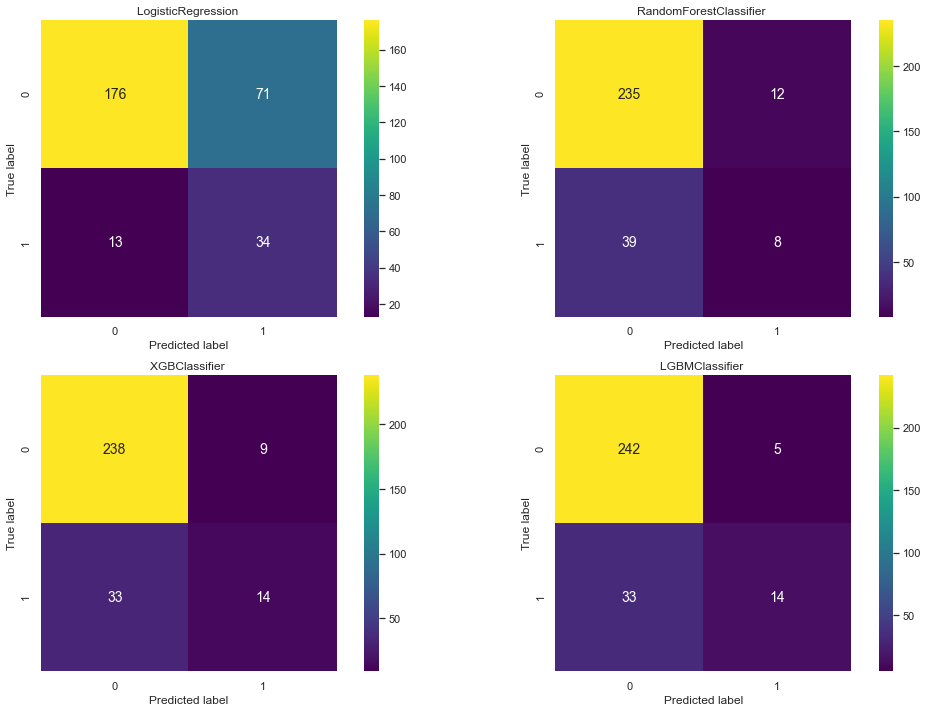

In [84]:
gu.plot_multiple_confusion_matrices(2, 2, X_test, y_test, classifiers, THRESHOLD)

As observed and according to our business metrics, we're trying to minimize the FN and maximize the TP. Thus, the algorithm that best suits our needs is the `LogisticRegression`. Although, it has the highest FP, for our case, it's not a bad idea to check on these employees, as we can discover new things about them and motivate them.

## 10.6 Probability distribution

Since `LogisticRegression` gives us the lowest FN and `LGBMClassifier` gives us the lowest FP. Let's check their probabilities distribution to see how the algorithms behave.

In [85]:
# instantiates the classifiers
lr_clf = LogisticRegression(random_state=SEED)
lgbm_clf = LGBMClassifier(random_state=SEED, n_jobs=-1)

# trains the classifiers
lr_clf.fit(X_balanced, y_balanced)
lgbm_clf.fit(X_balanced, y_balanced)

# store the predicted probabilities for class 1
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test)[:, 1]

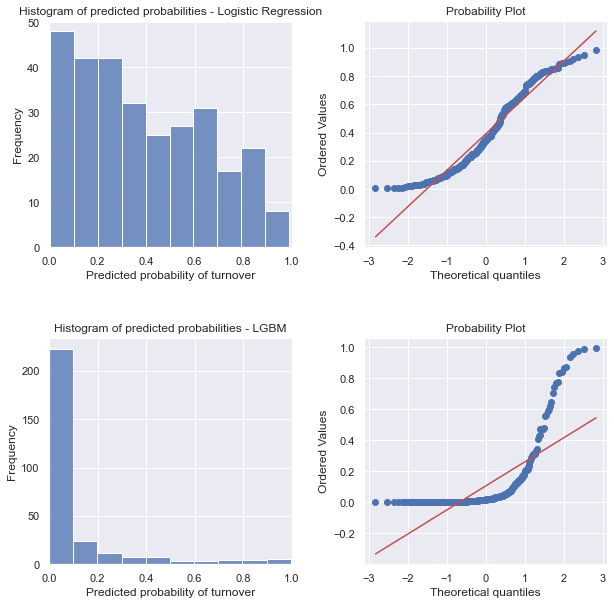

In [86]:
# set axes
fig, ax = plt.subplots()

# set fig size
ax.figure.set_size_inches(10, 10)

# plot histogram
plt.subplot(2, 2, 1)
ax = sns.histplot(y_pred_lr_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - Logistic Regression')
plt.xlabel('Predicted probability of turnover')
plt.ylabel('Frequency')

# plot probability
plt.subplot(2, 2, 2)
ax = stats.probplot(y_pred_lr_prob, plot=plt)


# plot histogram
plt.subplot(2, 2, 3)
ax = sns.histplot(y_pred_lgbm_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - LGBM')
plt.xlabel('Predicted probability of turnover')
plt.ylabel('Frequency')

# plot probability
plt.subplot(2, 2, 4)
ax = stats.probplot(y_pred_lgbm_prob, plot=plt)

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.4)

# displays the plot
plt.show()

For the context and challenge of our project, the `LogisticRegression` suits best than `LGBMClassifier`, because the later is more optimistic, that is, it predicts many more values that are closer to `0.0` than values closer to `1.0`.

In addition, looking at the `Probability Plot` for `LogisticRegression` the points are well distributed, it forms a smooth S-shaped curve and the red diagonal seems to form a 45 angle with the X-axis while for `LGBMClassifier` most of the points are gathered to  the left of the curve, the points form a Z-shaped curve and the red diagonal does not seem to form a 45 angle with the X-axis.

Thus, this just reinforces our previous decision on choosing the `LogisticRegression` as the classifier to continue the project.

## 10.7 Classification report

In [87]:
# makes predictions
y_pred_lr = lr_clf.predict(X_test)
y_pred_lgbm = lgbm_clf.predict(X_test)

print('Classification Report for ' + type(lr_clf).__name__)
print(classification_report(y_test, y_pred_lr))

print('\nClassification Report for ' + type(lgbm_clf).__name__)
print(classification_report(y_test, y_pred_lgbm))

Classification Report for LogisticRegression
              precision    recall  f1-score   support

           0       0.93      0.71      0.81       247
           1       0.32      0.72      0.45        47

    accuracy                           0.71       294
   macro avg       0.63      0.72      0.63       294
weighted avg       0.83      0.71      0.75       294


Classification Report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.74      0.30      0.42        47

    accuracy                           0.87       294
   macro avg       0.81      0.64      0.68       294
weighted avg       0.86      0.87      0.85       294



Other way to help us decide, is the `Classification Report`. As for this project, we are aiming at high recall rate for class `1`, the classification report that satisfies this condition is `LogisticRegression`'s.

# 11.0 Tuning Best Model

## Logistic Regression <font color="green"> (chosen as overall best)</font>

## 11.1 Hyperparameter Tuning

In [88]:
# instantiates classifier
lr_clf = LogisticRegression(random_state=SEED, n_jobs=-1)

In [89]:
# set up space dictionary with specified hyperparameters
space = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
         'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
         'penalty': ['l2', 'l1', 'elasticnet', None]}

In [90]:
# prepares RandomizedSearchCV object
lr_clf_cv = GridSearchCV(estimator=lr_clf, param_grid=space, scoring='recall', cv=10, verbose=2, n_jobs=-1)

In [91]:
# fits the RandomizedSearchCV object
lr_clf_cv.fit(X_balanced, y_balanced)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:    8.7s finished


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2', 'l1', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall', verbose=2)

In [92]:
# best estimator
lr_clf_cv.best_estimator_

LogisticRegression(C=1, n_jobs=-1, random_state=42, solver='newton-cg')

## 11.2 Predictions & Metrics

In [93]:
# Print the tuned parameters and score
print("\nTuned Parameters: {}".format(lr_clf_cv.best_params_)) 
print("\nBest score: {:.4f}".format(lr_clf_cv.best_score_))


Tuned Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Best score: 0.7881


In [94]:
# sets the threshold
THRESHOLD = 0.50

# extract the best estimator
lr_best_model = lr_clf_cv.best_estimator_

# predicts probabilities
lr_best_model_probs = lr_best_model.predict_proba(X_test)


# calculates classifiers performance
df_performance = gu.get_classifiers_performance(X_balanced, X_test, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, [lr_best_model])

df_performance

Training LogisticRegression...


,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,LogisticRegression,0.32381,0.723404,0.447368,0.777156,0.714286,0.290712


## 11.3 PR and ROC Curves

Recommended reading: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

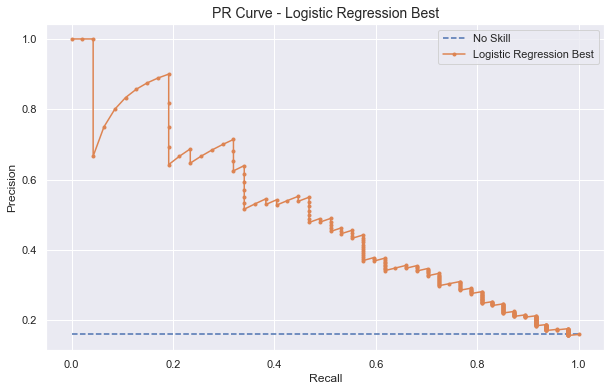

In [95]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
gu.plot_pr_auc(y_test, lr_best_model_probs, 'Logistic Regression Best')

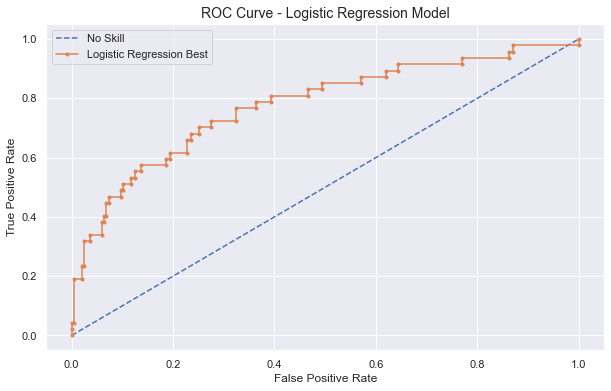

In [96]:
# sets the plot size
plt.figure(figsize=(10,6))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, lr_best_model_probs[:,1])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression Best')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# title
plt.title('ROC Curve - Logistic Regression Model', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

## 11.4 Confusion Matrix

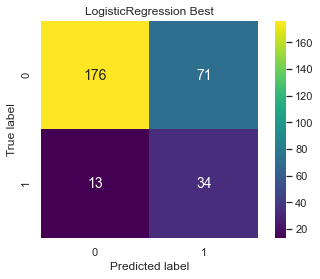

In [97]:
# keeps probabilities for the positive outcome only
df_lr_bm_probs = pd.DataFrame(lr_best_model_probs[:, 1], columns = ['prob_default'])

# applied the threshold
y_pred_bm = df_lr_bm_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

gu.plot_single_confusion_matrix(y_test, y_pred_bm, lr_best_model, 'Best')

# displays plot
plt.show()

As observed, we were able to minimize the number of FN cases while keeping the FP to its minimum possible.

## 11.5 Cross-validation scoring

Now, we should use cross-validation scoring with `cross_val_score()` to check the overall performance.

Recommended reading: https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [98]:
print(f'Ratio of negatives in full data set: {y.value_counts(normalize=True).to_dict()[0]}')
print(f'Ratio of positives in full data set: {y.value_counts(normalize=True).to_dict()[1]}')

Ratio of negatives in full data set: 0.8387755102040816
Ratio of positives in full data set: 0.16122448979591836


As observed, the original full data set is imbalanced, so we'll need to adopt the `StratifiedKFold` as our K-folding strategy for cross validation.

In [99]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [100]:
# calculates the cross validation scores
cv_scores = cross_val_score(lr_best_model, X, np.ravel(y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(lr_best_model, X, np.ravel(y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(lr_best_model, X, np.ravel(y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

Average precision: 0.7795 (+/- 0.1494)

Average recall: 0.2197 (+/- 0.1650)

Average ROC AUC: 0.8008 (+/- 0.0867)


The average scores are fair enough. We got a precision rate of 77.95%, a recall rate of 21.97% and a ROC AUC of 80.08%.

## 11.6 Saving the tuned model

In [101]:
# saves the model
pickle.dump(lr_best_model, open('model/model_people_analytics.pkl', 'wb'))

# 12.0 Business performance

## 12.1 Main metrics

In [102]:
# calculates classifiers performance
df_performance = gu.get_classifiers_performance(X_balanced, X_test, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, [lr_best_model])

df_performance

Training LogisticRegression...


,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,LogisticRegression,0.32381,0.723404,0.447368,0.777156,0.714286,0.290712


As we are dealing with imbalanced data set, the most relevant metric, in this case, is the **recall** (`0.723404`) which is used **when the False Negatives are crucial**. For this project, False Negatives are crucial, since losing these people could lead to company financial loss.

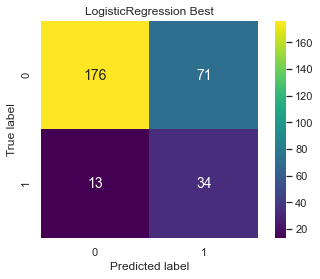

In [103]:
# sets the threshold
THRESHOLD = 0.50

# keeps probabilities for the positive outcome only
df_lr_bm_probs = pd.DataFrame(lr_best_model_probs[:, 1], columns = ['prob_default'])

# applied the threshold
y_pred_lr_bm = df_lr_bm_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

gu.plot_single_confusion_matrix(y_test, y_pred_lr_bm, lr_best_model, 'Best')

# displays plot
plt.show()

Let's recap the confusion matrix template and the best-worst scenario from **section 1.2**.

<img src="img/confusion-matrix.png" width="70%">

In addition, we can outline a **best-worst scenario** for an employee who leaves a company.

|                                  | Best scenario | Worst scenario |
|----------------------------------|---------------|----------------|
| **Cost \($\)**                   | 4,000         | 7,645          |
| **Time to fill a position \(days\)** | 42        | 52             |

Testing the model using a data set containing 294 records, it was able to correctly identify 34 (True Positives) and miss 13 (the False Negatives) from a total of 47 employees who tend to leave. Translating to the best-worst scenario, this means:

|                                  | Best scenario | Worst scenario |
|----------------------------------|---------------|----------------|
| **Total loss prevented \($\)**   | 136,000       | 259,930        |
| **Total time saved \(days\)**    | 1,428         | 1,768          |


In addition, **without the model**, the company would have 47 employees that could leave, translating it to **a total loss of \\$ 188,000 in the best scenario and \\$ 359,315 in the worst scenario**.

# 13.0 Testing the predictions

## 13.1 False Negatives & True Positives

In [104]:
df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)
df_y_pred = pd.DataFrame(y_pred_lr_bm)

df_y_test.columns = ['y_test']
df_y_pred.columns = ['y_pred']

df_test_final = pd.concat([df_y_pred, df_y_test, df_X_test], axis=1)

In [105]:
# false negatives or true postives
df_fn_tp = df_test_final[((df_test_final['y_pred'] == 0) & (df_test_final['y_test'] == 1)) | ((df_test_final['y_pred'] == 1) & (df_test_final['y_test'] == 1))]
df_fn_tp

,y_pred,y_test,age,daily_rate,distance_from_home,hourly_rate,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,stock_option_level,total_working_years,training_times_last_year,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,over_time,gender,business_travel,department,education,education_field,environment_satisfaction,job_involvement,job_level,job_role,job_satisfaction,marital_status,performance_rating,relationship_satisfaction,work_life_balance
2,1.0,1.0,0.452381,0.909807,0.035714,0.885714,0.056925,0.012126,0.666667,0.285714,0.000000,0.175,0.500000,0.000,0.000000,0.000000,0.000000,1.0,1.0,0.709524,0.653741,0.191837,0.055782,0.303401,0.255102,0.369388,0.176190,0.300680,0.319728,0.846259,0.206122,0.607483
24,0.0,1.0,0.380952,0.427344,0.178571,0.757143,0.102738,0.602610,0.222222,0.000000,0.000000,0.200,0.333333,0.100,0.111111,0.066667,0.176471,0.0,1.0,0.709524,0.653741,0.115646,0.315646,0.195238,0.590476,0.369388,0.198639,0.196599,0.319728,0.846259,0.312245,0.607483
36,0.0,1.0,0.761905,0.549034,0.071429,0.800000,0.088152,0.068902,0.111111,0.214286,0.000000,0.075,0.333333,0.075,0.111111,0.000000,0.117647,1.0,1.0,0.709524,0.303401,0.191837,0.108163,0.193197,0.255102,0.369388,0.056463,0.300680,0.457823,0.846259,0.312245,0.607483
45,0.0,1.0,0.547619,0.900501,0.392857,0.271429,0.976093,0.569604,0.111111,0.071429,0.000000,0.575,0.000000,0.550,0.833333,1.000000,0.470588,0.0,0.0,0.709524,0.653741,0.389116,0.089796,0.195238,0.590476,0.046939,0.054422,0.300680,0.457823,0.846259,0.293878,0.607483
69,0.0,1.0,0.428571,0.154617,0.285714,0.700000,0.125276,0.790323,0.000000,0.428571,0.333333,0.050,0.000000,0.025,0.000000,0.000000,0.000000,1.0,1.0,0.709524,0.653741,0.389116,0.315646,0.303401,0.255102,0.369388,0.198639,0.300680,0.457823,0.846259,0.187755,0.234014
122,0.0,1.0,0.904762,0.242663,0.464286,0.600000,0.208215,0.097009,1.000000,0.500000,1.000000,0.175,0.333333,0.125,0.222222,0.266667,0.176471,1.0,0.0,0.709524,0.653741,0.270748,0.412245,0.195238,0.590476,0.369388,0.198639,0.190476,0.457823,0.846259,0.187755,0.607483
126,1.0,1.0,0.952381,0.032212,0.785714,0.914286,0.489889,0.055049,0.111111,0.071429,0.333333,1.000,0.500000,1.000,0.555556,1.000000,0.352941,0.0,0.0,0.709524,0.653741,0.270748,0.315646,0.303401,0.590476,0.148299,0.089116,0.312245,0.457823,0.846259,0.293878,0.234014
132,1.0,1.0,0.309524,0.314961,0.678571,0.585714,0.186940,0.911223,0.333333,0.000000,0.333333,0.100,0.333333,0.050,0.111111,0.133333,0.117647,1.0,0.0,0.709524,0.303401,0.389116,0.412245,0.195238,0.056463,0.363265,0.221769,0.300680,0.457823,0.846259,0.312245,0.607483
136,1.0,1.0,0.785714,0.750179,0.250000,0.328571,0.507688,0.925758,0.222222,0.285714,0.000000,0.450,0.333333,0.100,0.111111,0.000000,0.176471,0.0,1.0,0.188435,0.653741,0.270748,0.412245,0.193197,0.056463,0.148299,0.098639,0.312245,0.319728,0.846259,0.293878,0.607483
182,0.0,1.0,0.547619,0.897638,0.678571,0.571429,0.112217,0.788356,0.111111,0.785714,0.000000,0.100,0.833333,0.100,0.166667,0.000000,0.117647,1.0,0.0,0.709524,0.303401,0.191837,0.108163,0.195238,0.590476,0.369388,0.056463,0.190476,0.319728,0.153741,0.293878,0.234014


# 14.0 Deploying the model to production

## 14.1 Web application architecture

![](img/web-app-architecture.png)

## 14.2 Creating the Pipeline

In [106]:
import pickle
import inflection
import pandas as pd
import numpy as np


class Pipeline(object):

    def __init__(self):
        self.home_path = ''

        # loads the rescaling
        self.numerical_vars_scaler = pickle.load(open(self.home_path + 'parameter/numerical_vars_scaler.pkl', 'rb'))

        # loads model
        self.model = pickle.load(open('model/model_people_analytics.pkl', 'rb'))

    def get_attribute_frequency(self, attribute):

        # creates a dictionary from value counts
        count_dict_attribute = attribute.value_counts().to_dict()

        # stores values as DataFrame
        df_count_attribute = pd.DataFrame(count_dict_attribute.items(), columns=['Value', 'Count'])

        # calculates the frequency for each value
        df_count_attribute['frequency'] = df_count_attribute['Count'] / df_count_attribute['Count'].sum()

        # gets a dictionary for the frequency
        frequency_attribute = df_count_attribute.set_index('Value').to_dict()['frequency']

        return frequency_attribute

    def get_encoded_frequencies(self, data_frame):

        # creates an empty DataFrame
        encoded_freq = pd.DataFrame()

        # creates columns for frequency
        for column in data_frame.columns:
            encoded_freq[column] = data_frame[column].map(self.get_attribute_frequency(data_frame[column]))

        return encoded_freq

    def make_rename_columns(self, input_data):

        # makes a copy
        data = input_data.copy()

        # stores the old column names
        cols_old = data.columns

        # snake case
        def snakecase(x): return inflection.underscore(x)

        # creates new columns from old columns in snakecase
        cols_new = list(map(snakecase, cols_old))

        # renames the old columns
        data.columns = cols_new

        return data

    def make_label_change(self, input_data):

        # makes a copy
        data = input_data.copy()

        # employee's education level
        data['education'] = data['education'].apply(lambda x: 'Bellow College' if x == 1
                                                    else 'College' if x == 2
                                                    else 'Bachelor' if x == 3
                                                    else 'Master' if x == 4
                                                    else 'Doctor')

        # how satisfied the employee is with the company's environment
        data['environment_satisfaction'] = data['environment_satisfaction'].apply(lambda x: 'Low' if x == 1
                                                                                  else 'Medium' if x == 2
                                                                                  else 'High' if x == 3
                                                                                  else 'Very High')

        # how involved the employee feels with his/her job
        data['job_involvement'] = data['job_involvement'].apply(lambda x: 'Low' if x == 1
                                                                else 'Medium' if x == 2
                                                                else 'High' if x == 3
                                                                else 'Very High')

        # employee's job level
        data['job_level'] = data['job_level'].apply(lambda x: 'Junior' if x == 1
                                                    else 'Mid' if x == 2
                                                    else 'Senior' if x == 3
                                                    else 'Manager' if x == 4
                                                    else 'Director')

        # how satisfied the employee feels with his/her job
        data['job_satisfaction'] = data['job_satisfaction'].apply(lambda x: 'Low' if x == 1
                                                                  else 'Medium' if x == 2
                                                                  else 'High' if x == 3
                                                                  else 'Very High')

        # employee's performance rating
        data['performance_rating'] = data['performance_rating'].apply(lambda x: 'Low' if x == 1
                                                                      else 'Good' if x == 2
                                                                      else 'Excellent' if x == 3
                                                                      else 'Outstanding')

        # how satisfied the employee feels with the relationship with his/her manager
        data['relationship_satisfaction'] = data['relationship_satisfaction'].apply(lambda x: 'Low' if x == 1
                                                                                    else 'Medium' if x == 2
                                                                                    else 'High' if x == 3
                                                                                    else 'Very High')

        # how the employee feels about his/her work life balance
        data['work_life_balance'] = data['work_life_balance'].apply(lambda x: 'Bad' if x == 1
                                                                    else 'Good' if x == 2
                                                                    else 'Better' if x == 3
                                                                    else 'Best')
        return data

    def make_data_prep(self, input_data):

        # makes a copy
        data = input_data.copy()

        # gets only numerical attributes
        num_attributes = data.select_dtypes(include=['int64'])

        # gets only binary attributes
        binary_attributes = data[['over_time', 'gender']]

        # gets only categorical attributes
        cat_attributes = data.select_dtypes(exclude=['int64'])

        # drops the target var and binary attribute
        cat_attributes.drop(['over_time', 'gender'], axis=1, inplace=True)

        # SCALING NUMERICAL VARS #
        # ---------------------- #

        # we need to scale the data because the range of variables vary a lot within them
        # treat the features equally
        scaled_numerical = self.numerical_vars_scaler.transform(num_attributes)

        # gets the Data Frame version of numerical scaled for later manipulation
        df_scaled_numerical = pd.DataFrame(scaled_numerical)

        # renaming the columns of result Data Frame
        df_scaled_numerical.columns = num_attributes.columns

        # ENCODING BINARY VARS #
        # -------------------- #

        # creates an empty DataFrame
        df_binary_att_encoded = pd.DataFrame()

        # encondes over_time
        df_binary_att_encoded['over_time'] = binary_attributes['over_time'].apply(lambda x: 1 if x == 'Yes' else 0)

        # encondes gender
        df_binary_att_encoded['gender'] = binary_attributes['gender'].apply(lambda x: 1 if x == 'Male' else 0)

        # ENCODING CATEGORICAL VARS #
        # ------------------------- #

        # resets the index
        cat_attributes.reset_index(drop=True, inplace=True)

        # frequency encodes categorical vars
        cat_attr_freq_encoded = self.get_encoded_frequencies(cat_attributes)

        # joins scaled with encoded attributes
        data_prep = pd.concat([df_scaled_numerical, df_binary_att_encoded, cat_attr_freq_encoded], axis=1)

        return data_prep

    def transform(self, input_data):

        # makes a copy
        data = input_data.copy()

        # renames the columns to snakecase
        data_renamed_cols = self.make_rename_columns(data)

        # drops unused columns
        data_renamed_cols.drop(['over18', 'standard_hours', 'employee_count', 'employee_number'], axis=1, inplace=True)

        # changes data labels
        data_labels_changed = self.make_label_change(data_renamed_cols)

        # preps the data
        data_prep = self.make_data_prep(data_labels_changed)

        return data_prep

    def reorder_columns(self, input_data):

        # makes a copy
        data = input_data.copy()

        data = data[['employee_number', 'age', 'business_travel', 'daily_rate', 'department',
                     'distance_from_home', 'education', 'education_field', 'employee_count',
                     'environment_satisfaction', 'gender', 'hourly_rate',
                     'job_involvement', 'job_level', 'job_role', 'job_satisfaction',
                     'marital_status', 'monthly_income', 'monthly_rate',
                     'num_companies_worked', 'over18', 'over_time', 'percent_salary_hike',
                     'performance_rating', 'relationship_satisfaction', 'standard_hours',
                     'stock_option_level', 'total_working_years', 'training_times_last_year',
                     'work_life_balance', 'years_at_company', 'years_in_current_role',
                     'years_since_last_promotion', 'years_with_curr_manager']]
        return data

    def predict(self, input_data):

        # makes a copy
        data = input_data.copy()

        # creates a new Data Frame
        test_data = pd.DataFrame()

        # creates new column for comparison
        test_data['employee_number'] = data['employee_number'].reset_index(drop=True)

        # transforms the data: renames cols, scales and encodes
        transformed_data = self.transform(data)

        # predicts
        predictions = self.model.predict(transformed_data)

        # creates y_pred column
        test_data['y_pred'] = predictions

        # filters the ones who tend to leave
        df_tend_to_leave = test_data[test_data['y_pred'] == 1]

        # filters original data set to check more info about the employee
        filter_employees = data['employee_number'].isin(set(df_tend_to_leave['employee_number']))
        df_employees = data[filter_employees]

        # reorder de columns
        df_employees = self.reorder_columns(df_employees)

        return df_employees

## 14.3 Testing the Pipeline

In [107]:
# loads data to test
original_data = pd.read_csv('data/test_data.csv')

In [108]:
# instantiates PeopleAnalytics class
pipeline = Pipeline()

# prediction
df_response = pipeline.predict(original_data)

df_response

/Users/brunokatekawa/.pyenv/versions/3.8.5/envs/study_env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,employee_number,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over18,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
2,1714,24,Travel_Rarely,240,Human Resources,22,1,Human Resources,1,4,Male,58,1,1,Human Resources,3,Married,1555,11585,1,Y,No,11,3,3,80,1,1,2,3,1,0,0,0
6,577,35,Travel_Rarely,144,Research & Development,22,3,Life Sciences,1,4,Male,46,1,1,Laboratory Technician,3,Single,4230,19225,0,Y,No,15,3,3,80,0,6,2,3,5,4,4,3
10,925,47,Travel_Rarely,1454,Sales,2,4,Life Sciences,1,4,Female,65,2,1,Sales Representative,4,Single,3294,13137,1,Y,Yes,18,3,1,80,0,3,3,2,3,2,1,2
12,852,44,Travel_Rarely,625,Research & Development,4,3,Medical,1,4,Male,50,3,2,Healthcare Representative,2,Single,5933,5197,9,Y,No,12,3,4,80,0,10,2,2,5,2,2,3
14,2007,22,Travel_Rarely,581,Research & Development,1,2,Life Sciences,1,4,Male,63,3,1,Research Scientist,3,Single,3375,17624,0,Y,No,12,3,4,80,0,4,2,4,3,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,608,26,Travel_Frequently,426,Human Resources,17,4,Life Sciences,1,2,Female,58,3,1,Human Resources,3,Divorced,2741,22808,0,Y,Yes,11,3,2,80,1,8,2,2,7,7,1,0
362,785,47,Travel_Frequently,719,Sales,27,2,Life Sciences,1,2,Female,77,4,2,Sales Executive,3,Single,6397,10339,4,Y,Yes,12,3,4,80,0,8,2,3,5,4,1,3
363,792,26,Travel_Frequently,575,Research & Development,1,2,Life Sciences,1,1,Female,71,1,1,Laboratory Technician,4,Divorced,4364,5288,3,Y,No,14,3,1,80,1,5,2,3,2,2,2,0
364,1640,37,Travel_Rarely,1470,Research & Development,10,3,Medical,1,2,Female,71,3,1,Research Scientist,2,Married,3936,9953,1,Y,No,11,3,1,80,1,8,2,1,8,4,7,7
